# Workload profiling

This notebook deals with two main goals.
1. Find an unsupervised methodology for grouping together similar workload, starting from their key features, namely:
    - CPU
    - Memory
    - Disk
    - Level of parallelization
    - Runtime length
2. Evaluate these results looking at:
    1. Unsupervised learning performance metrics
    2. Workload features patterns
    3. Static metadata patterns

## Imports

In [79]:
import pandas as pd

import dask.dataframe as dd
from dask.delayed import delayed

import numpy as np
import random

import os
from collections import Counter
import pickle

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

import hdbscan

from time import time

from gcd_dask_mgmt import extract_delayed_dask_dataframe

from clustering_functions import extract_kmeans_stats

from plot_functions import plot_silhouette_results
from plot_functions import plot_feature_scatter

## Extract Job Stats

In [2]:
# Change this with your destination directory
DESTINATION_DIRECTORY = "/data/cloud_data/Google-clusterdata-2011-2/"

In [3]:
data_path = os.path.join(DESTINATION_DIRECTORY, 'clusterdata-2011-2')
schema_path = os.path.join(data_path, 'schema.csv')

In [4]:
df_schema = pd.read_csv(schema_path)

In [5]:
readings_job_events_df = extract_delayed_dask_dataframe(data_path, df_schema, gcd_collection_name="job_events", 
                                                        interval_start=0, interval_end=500)

In [6]:
job_stats = readings_job_events_df["scheduling class"].value_counts().compute()
unique_job = pd.DataFrame({'scheduling class' : readings_job_events_df.groupby(["job ID"])["scheduling class"].mean().compute()}).reset_index()


In [7]:
unique_job_stats = unique_job["scheduling class"].value_counts()
unique_job_stats

0.000000    257275
1.000000    215109
2.000000    194510
3.000000      5177
2.333333         2
1.666667         1
Name: scheduling class, dtype: int64

In [8]:
unique_job.head(20)

,job ID,scheduling class
0,3418309,3.0
1,3418314,3.0
2,3418319,3.0
3,3418324,3.0
4,3418329,3.0
5,3418334,3.0
6,3418339,3.0
7,3418356,3.0
8,3418363,3.0
9,3418368,3.0


## Sample jobs

The Google cluster data traces are too large to be completely analyzed. Thus, to perform a thorough but lean analysis, we need to perform some sampling. 
A relevant feature that can be used for this goal is *scheduling class* as it separates jobs according to their *latency sensitiveness*. 

However, the labels in the trace are unbalanced. Thus, we need techniques to sample while keeping the ratio, in order to recreate the conditions present in the complete data set.

**Stratified sampling**: https://www.scribbr.com/methodology/stratified-sampling/

In [9]:
def stratified_proportional_sampling(dataframe_in, filter_metric, filter_values, target_metric, sampling_perc):
    target_vals = []
    for val in filter_values:
        val_array = dataframe_in[dataframe_in[filter_metric] == val][target_metric].values
        target_vals = target_vals + random.sample(list(val_array), int(val_array.shape[0] * sampling_perc))
    return target_vals

In [10]:
selected_job_IDs = stratified_proportional_sampling(unique_job, 'scheduling class', np.arange(0., 4.), 'job ID', 0.1)

In [11]:
len(selected_job_IDs)

67205

## Extract Task infos

Analyze the information given a selected job.

In [12]:
readings_task_usage = extract_delayed_dask_dataframe(data_path, df_schema, gcd_collection_name="task_usage", 
                                                        interval_start=0, interval_end=500)

In [13]:
readings_task_usage_df = readings_task_usage[readings_task_usage['job ID'].isin(selected_job_IDs)].groupby(["job ID"])[['CPU rate', 'canonical memory usage', 'local disk space usage']].agg(['mean','std']).compute()

/opt/anaconda3/envs/neuralnets/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
count_active_task = readings_task_usage[readings_task_usage['job ID'].isin(selected_job_IDs)].groupby(["job ID", "end time"])[["task index"]].count().compute()

In [15]:
count_active_task

task index
job ID     end time                 
3418356    900000000               5
           1200000000              5
           1500000000              5
           1800000000              5
           2100000000              5
...                              ...
6486631154 2506188000000           1
           2506189000000           1
6486631394 2506196000000           1
           2506199000000           1
           2506200000000           1

[7164443 rows x 1 columns]

In [16]:
count_active_task_final = count_active_task.groupby("job ID")["task index"].agg(["mean", "std"])
count_active_task_final["mean"].values

array([4.99820402, 3.99688697, 1.99892241, ..., 1.28571429, 1.        ,
       1.        ])

## Create the dataframe to be used as input for the unsupervised learning

In [17]:
readings_task_usage_df

CPU rate           canonical memory usage            \
                mean       std                   mean       std   
job ID                                                            
3418356     0.036646  0.018963               0.080511  0.000850   
3418405     0.033089  0.023353               0.082067  0.001213   
6724949     0.000554  0.000375               0.078749  0.001790   
28185708    0.000654  0.000272               0.005977  0.001609   
124371644   0.000083  0.000133               0.020451  0.000204   
...              ...       ...                    ...       ...   
6486612269  0.001944  0.002809               0.000313  0.000542   
6486612710  0.021116  0.021414               0.003314  0.003417   
6486630408  0.000629  0.001184               0.000204  0.000413   
6486631154  0.000535  0.000899               0.000249  0.000498   
6486631394  0.002621  0.001527               0.000614  0.000533   

           local disk space usage            
                             mean       std  
job ID                                       
3418356                  0.000282  0.000072  
3418405                  0.000218  0.000042  
6724949                  0.000192  0.000014  
28185708                 0.000000  0.000000  
124371644                0.000047  0.000002  
...                           ...       ...  
6486612269               0.000000  0.000000  
6486612710               0.000001  0.000001  
6486630408               0.000000  0.000000  
6486631154               0.000000  0.000000  
6486631394               0.000000  0.000000  

[65421 rows x 6 columns]

In [18]:
readings_task_usage_df.insert( 6,("active tasks", "mean"), count_active_task_final["mean"].values)
readings_task_usage_df.insert( 7,("active tasks", "std"), count_active_task_final["std"].values)

In [19]:
readings_task_usage_df

CPU rate           canonical memory usage            \
                mean       std                   mean       std   
job ID                                                            
3418356     0.036646  0.018963               0.080511  0.000850   
3418405     0.033089  0.023353               0.082067  0.001213   
6724949     0.000554  0.000375               0.078749  0.001790   
28185708    0.000654  0.000272               0.005977  0.001609   
124371644   0.000083  0.000133               0.020451  0.000204   
...              ...       ...                    ...       ...   
6486612269  0.001944  0.002809               0.000313  0.000542   
6486612710  0.021116  0.021414               0.003314  0.003417   
6486630408  0.000629  0.001184               0.000204  0.000413   
6486631154  0.000535  0.000899               0.000249  0.000498   
6486631394  0.002621  0.001527               0.000614  0.000533   

           local disk space usage           active tasks              
                             mean       std         mean         std  
job ID                                                                
3418356                  0.000282  0.000072     4.998204    0.052449  
3418405                  0.000218  0.000042     3.996887    0.061824  
6724949                  0.000192  0.000014     1.998922    0.032811  
28185708                 0.000000  0.000000     9.776516    3.269454  
124371644                0.000047  0.000002     1.999162    0.028940  
...                           ...       ...          ...         ...  
6486612269               0.000000  0.000000     1.000000    0.000000  
6486612710               0.000001  0.000001    22.382022  105.542592  
6486630408               0.000000  0.000000     1.285714    0.487950  
6486631154               0.000000  0.000000     1.000000    0.000000  
6486631394               0.000000  0.000000     1.000000    0.000000  

[65421 rows x 8 columns]

In [20]:
count_runtime = readings_task_usage[readings_task_usage['job ID'].isin(selected_job_IDs)].groupby(["job ID"])[["start time", "end time"]].agg(["min", "max"]).compute()

In [21]:
count_runtime

start time                      end time               
                      min            max            min            max
job ID                                                                
3418356         600000000  2505900000000      900000000  2506200000000
3418405         600000000  2505900000000      900000000  2506200000000
6724949         600000000  2505900000000      900000000  2506200000000
28185708        600000000  2505900000000      900000000  2506200000000
124371644       600000000  2505900000000      900000000  2506200000000
...                   ...            ...            ...            ...
6486612269  2505960000000  2505983000000  2505970000000  2505984000000
6486612710  2505978000000  2506163000000  2505994000000  2506200000000
6486630408  2506115000000  2506191000000  2506132000000  2506200000000
6486631154  2506126000000  2506188000000  2506139000000  2506189000000
6486631394  2506137000000  2506199000000  2506196000000  2506200000000

[65421 rows x 4 columns]

In [22]:
readings_task_usage_df[("job runtime", "vals")] = count_runtime["end time"]["max"].values - count_runtime["start time"]["min"].values 

In [23]:
readings_task_usage_df

CPU rate           canonical memory usage            \
                mean       std                   mean       std   
job ID                                                            
3418356     0.036646  0.018963               0.080511  0.000850   
3418405     0.033089  0.023353               0.082067  0.001213   
6724949     0.000554  0.000375               0.078749  0.001790   
28185708    0.000654  0.000272               0.005977  0.001609   
124371644   0.000083  0.000133               0.020451  0.000204   
...              ...       ...                    ...       ...   
6486612269  0.001944  0.002809               0.000313  0.000542   
6486612710  0.021116  0.021414               0.003314  0.003417   
6486630408  0.000629  0.001184               0.000204  0.000413   
6486631154  0.000535  0.000899               0.000249  0.000498   
6486631394  0.002621  0.001527               0.000614  0.000533   

           local disk space usage           active tasks              \
                             mean       std         mean         std   
job ID                                                                 
3418356                  0.000282  0.000072     4.998204    0.052449   
3418405                  0.000218  0.000042     3.996887    0.061824   
6724949                  0.000192  0.000014     1.998922    0.032811   
28185708                 0.000000  0.000000     9.776516    3.269454   
124371644                0.000047  0.000002     1.999162    0.028940   
...                           ...       ...          ...         ...   
6486612269               0.000000  0.000000     1.000000    0.000000   
6486612710               0.000001  0.000001    22.382022  105.542592   
6486630408               0.000000  0.000000     1.285714    0.487950   
6486631154               0.000000  0.000000     1.000000    0.000000   
6486631394               0.000000  0.000000     1.000000    0.000000   

              job runtime  
                     vals  
job ID                     
3418356     2505600000000  
3418405     2505600000000  
6724949     2505600000000  
28185708    2505600000000  
124371644   2505600000000  
...                   ...  
6486612269       24000000  
6486612710      222000000  
6486630408       85000000  
6486631154       63000000  
6486631394       63000000  

[65421 rows x 9 columns]

In [24]:
readings_task_usage_df.to_csv("data/sample_jobs_summary_10perc.csv")

## Clustering (start from here with CSV)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(test_data)For future experiments : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

In [26]:
readings_task_usage_df = pd.read_csv("data/sample_jobs_summary_10perc.csv", header=[0,1], index_col=[0])

In [27]:
readings_task_usage_df

CPU rate           canonical memory usage            \
                mean       std                   mean       std   
job ID                                                            
3418356     0.036646  0.018963               0.080511  0.000850   
3418405     0.033089  0.023353               0.082067  0.001213   
6724949     0.000554  0.000375               0.078749  0.001790   
28185708    0.000654  0.000272               0.005977  0.001609   
124371644   0.000083  0.000133               0.020451  0.000204   
...              ...       ...                    ...       ...   
6486612269  0.001944  0.002809               0.000313  0.000542   
6486612710  0.021116  0.021414               0.003314  0.003417   
6486630408  0.000629  0.001184               0.000204  0.000413   
6486631154  0.000535  0.000899               0.000249  0.000498   
6486631394  0.002621  0.001527               0.000614  0.000533   

           local disk space usage           active tasks              \
                             mean       std         mean         std   
job ID                                                                 
3418356                  0.000282  0.000072     4.998204    0.052449   
3418405                  0.000218  0.000042     3.996887    0.061824   
6724949                  0.000192  0.000014     1.998922    0.032811   
28185708                 0.000000  0.000000     9.776516    3.269454   
124371644                0.000047  0.000002     1.999162    0.028940   
...                           ...       ...          ...         ...   
6486612269               0.000000  0.000000     1.000000    0.000000   
6486612710               0.000001  0.000001    22.382022  105.542592   
6486630408               0.000000  0.000000     1.285714    0.487950   
6486631154               0.000000  0.000000     1.000000    0.000000   
6486631394               0.000000  0.000000     1.000000    0.000000   

              job runtime  
                     vals  
job ID                     
3418356     2505600000000  
3418405     2505600000000  
6724949     2505600000000  
28185708    2505600000000  
124371644   2505600000000  
...                   ...  
6486612269       24000000  
6486612710      222000000  
6486630408       85000000  
6486631154       63000000  
6486631394       63000000  

[65421 rows x 9 columns]

In [28]:
readings_task_usage_df.dropna(inplace=True)

### Perform some preprocessing

In [29]:
scaler = MinMaxScaler()

In [30]:
scaled = scaler.fit_transform(readings_task_usage_df)

In [31]:
scaled

array([[1.48922239e-01, 1.00775407e-01, 1.07062358e-01, ...,
        3.90545251e-03, 2.07614082e-05, 1.00000000e+00],
       [1.34466958e-01, 1.24101761e-01, 1.09131625e-01, ...,
        2.92736431e-03, 2.44721674e-05, 1.00000000e+00],
       [2.25062764e-03, 1.99056370e-03, 1.04719639e-01, ...,
        9.75749118e-04, 1.29877677e-05, 1.00000000e+00],
       ...,
       [2.55795427e-03, 6.28987637e-03, 2.71557329e-04, ...,
        2.79086202e-04, 1.93148783e-04, 3.31258247e-05],
       [2.17299233e-03, 4.77522152e-03, 3.30984043e-04, ...,
        0.00000000e+00, 0.00000000e+00, 2.43454856e-05],
       [1.06523256e-02, 8.11643416e-03, 8.16312057e-04, ...,
        0.00000000e+00, 0.00000000e+00, 2.43454856e-05]])

## K-Means

### K-Means = 2

In [32]:
clusterer_2, cluster_labels_2, silhouette_avg_2, sample_silhouette_values_2 = extract_kmeans_stats(scaled, 2)

For n_clusters = 2 The average silhouette_score is : 0.9299151370885901


In [33]:
Counter(cluster_labels_2)

Counter({0: 347, 1: 64586})

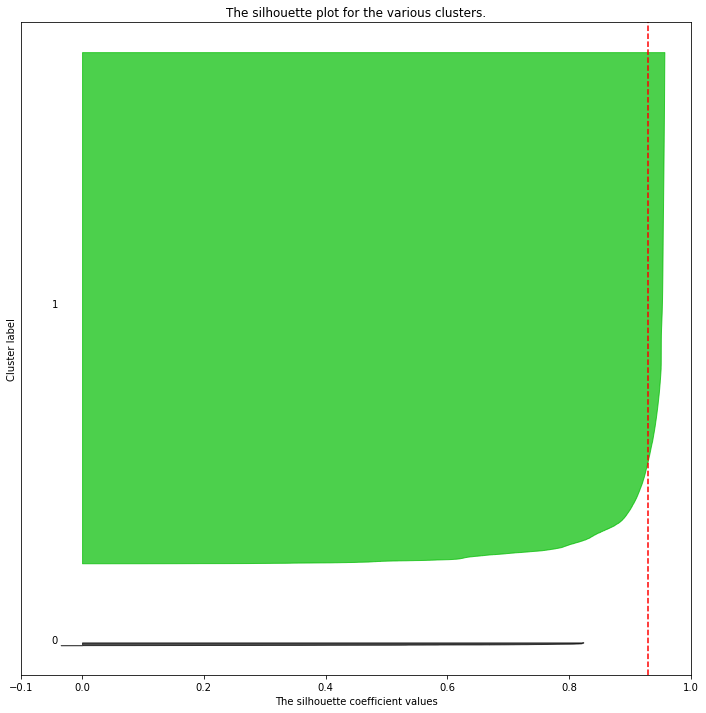

In [34]:
plot_silhouette_results(cluster_labels_2, silhouette_avg_2, sample_silhouette_values_2, 2)

Text(0.5, 0.98, 'CPU rate analysis for KMeans clustering on sample data with n_clusters = 2')

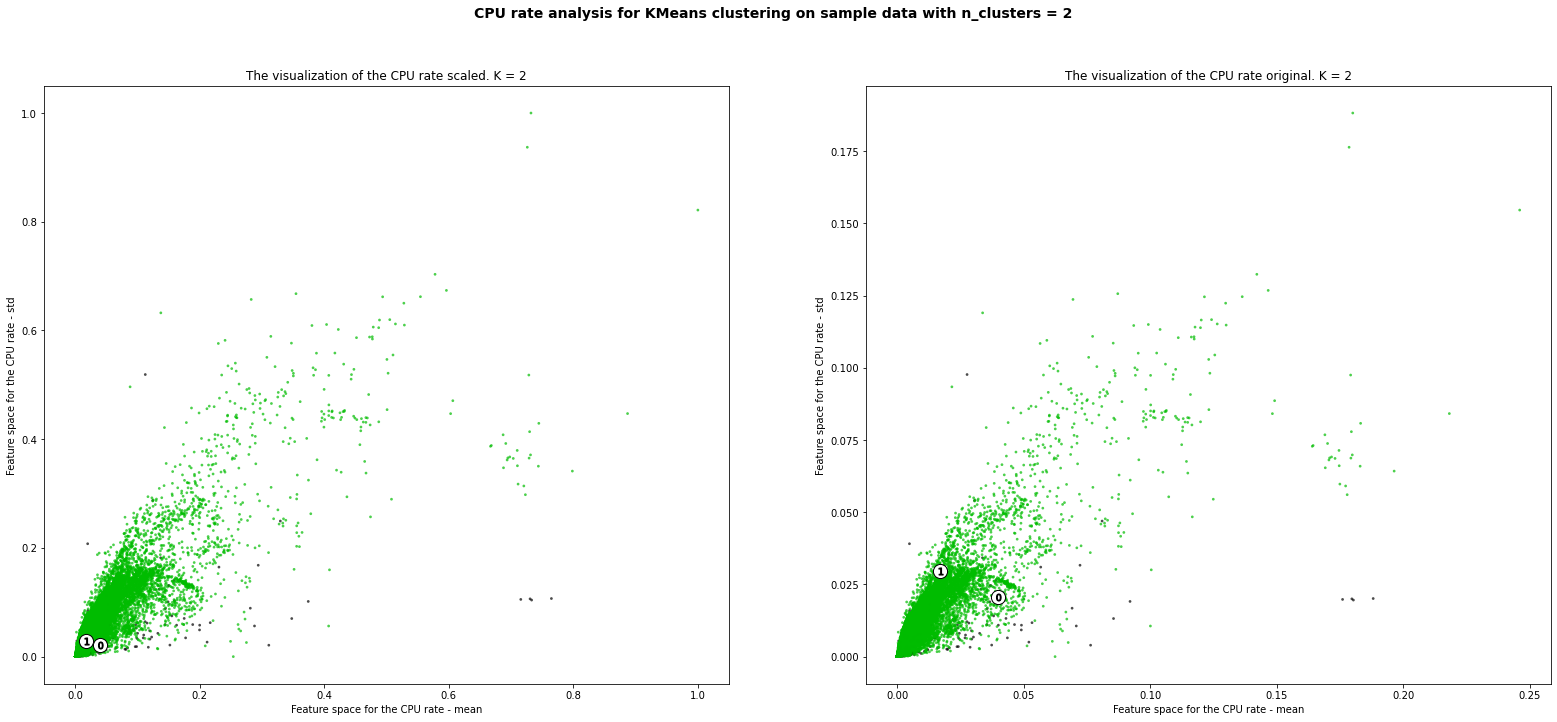

In [46]:
n_clusters = 2

feature = "CPU rate"

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer_2, cluster_labels_2, feature, 0, 1, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clusterer_2, cluster_labels_2, feature, 0, 1, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'canonical memory usage analysis for KMeans clustering on sample data with n_clusters = 2')

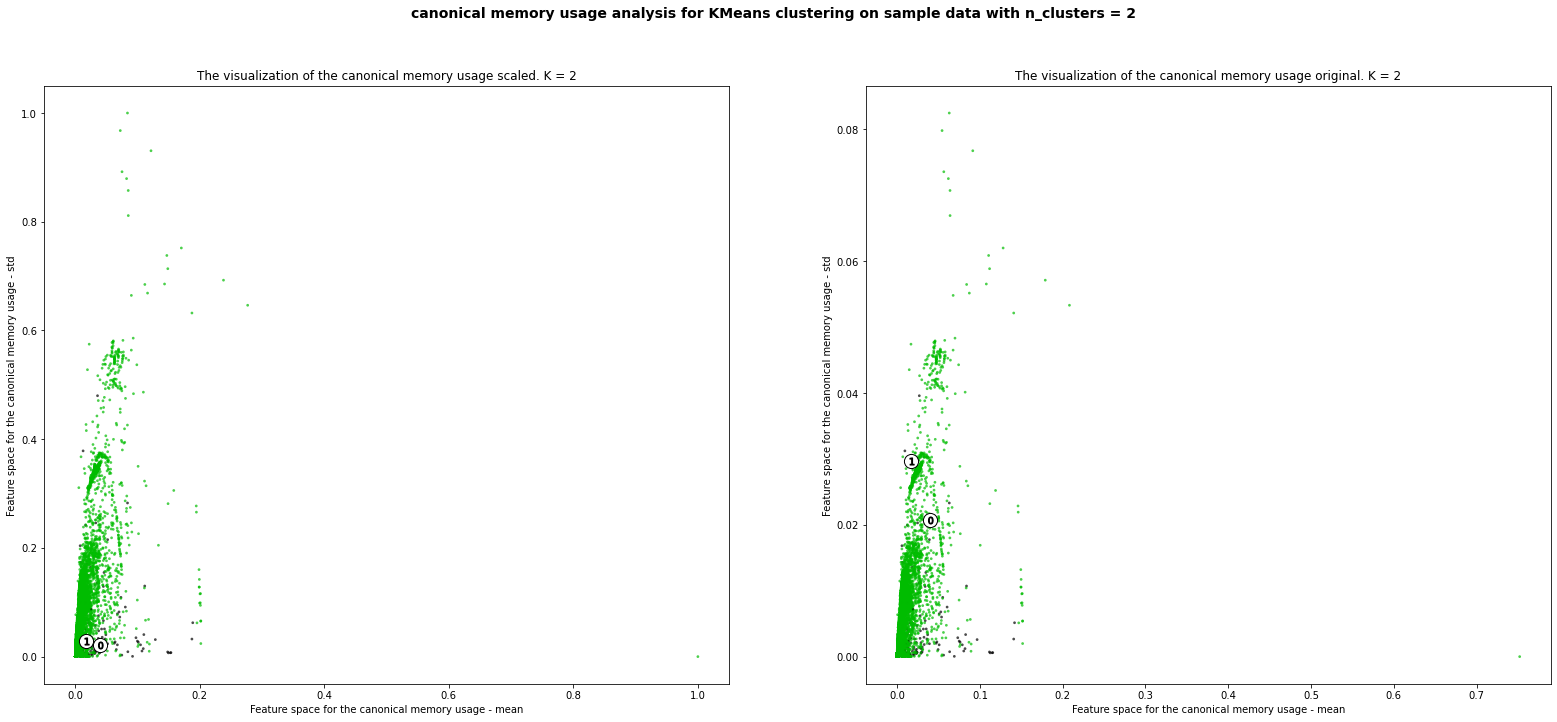

In [47]:
n_clusters = 2

feature = "canonical memory usage"

dim_1 = 2
dim_2 = 3

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer_2, cluster_labels_2, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clusterer_2, cluster_labels_2, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'disk usage analysis for KMeans clustering on sample data with n_clusters = 2')

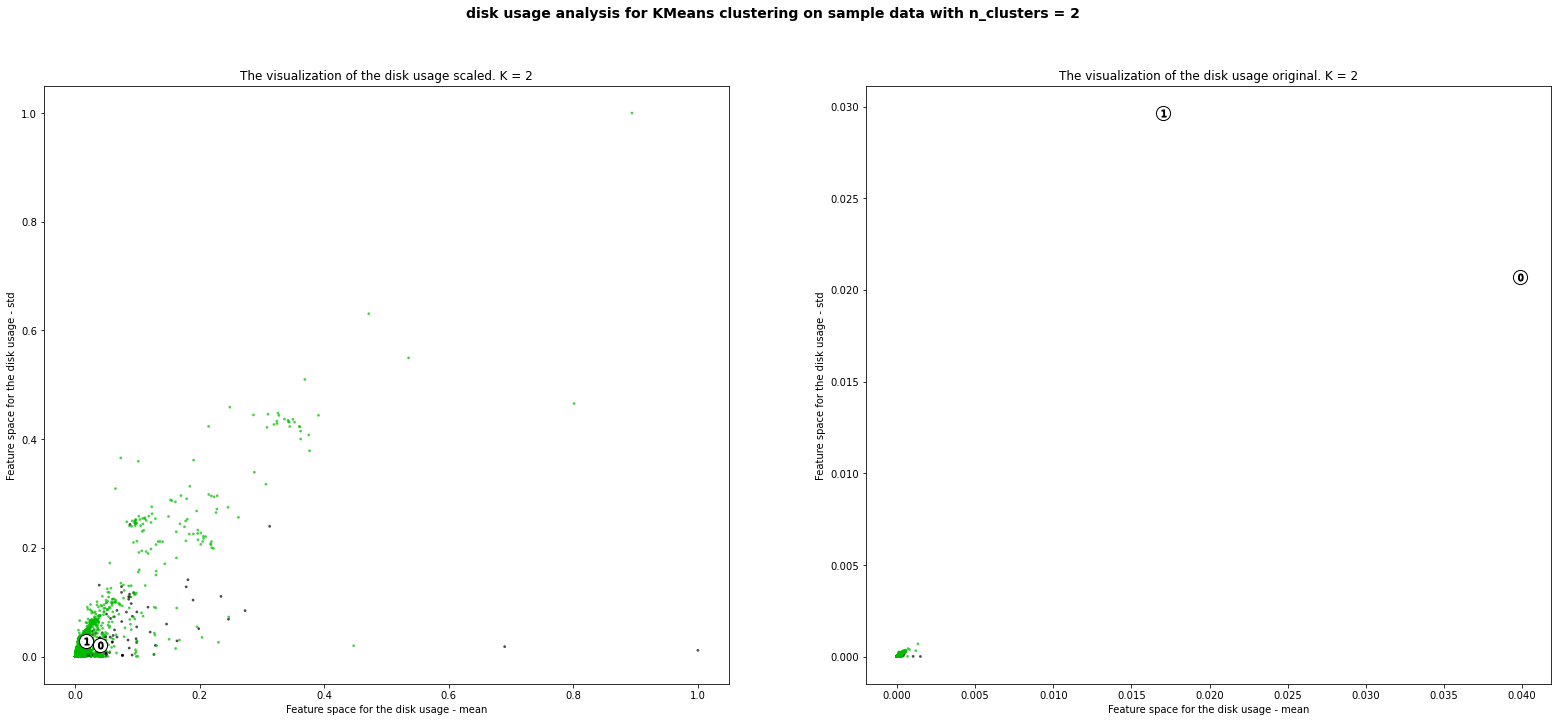

In [37]:
n_clusters = 2

feature = "disk usage"

dim_1 = 4
dim_2 = 5

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer_2, cluster_labels_2, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clusterer_2, cluster_labels_2, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'active tasks analysis for KMeans clustering on sample data with n_clusters = 2')

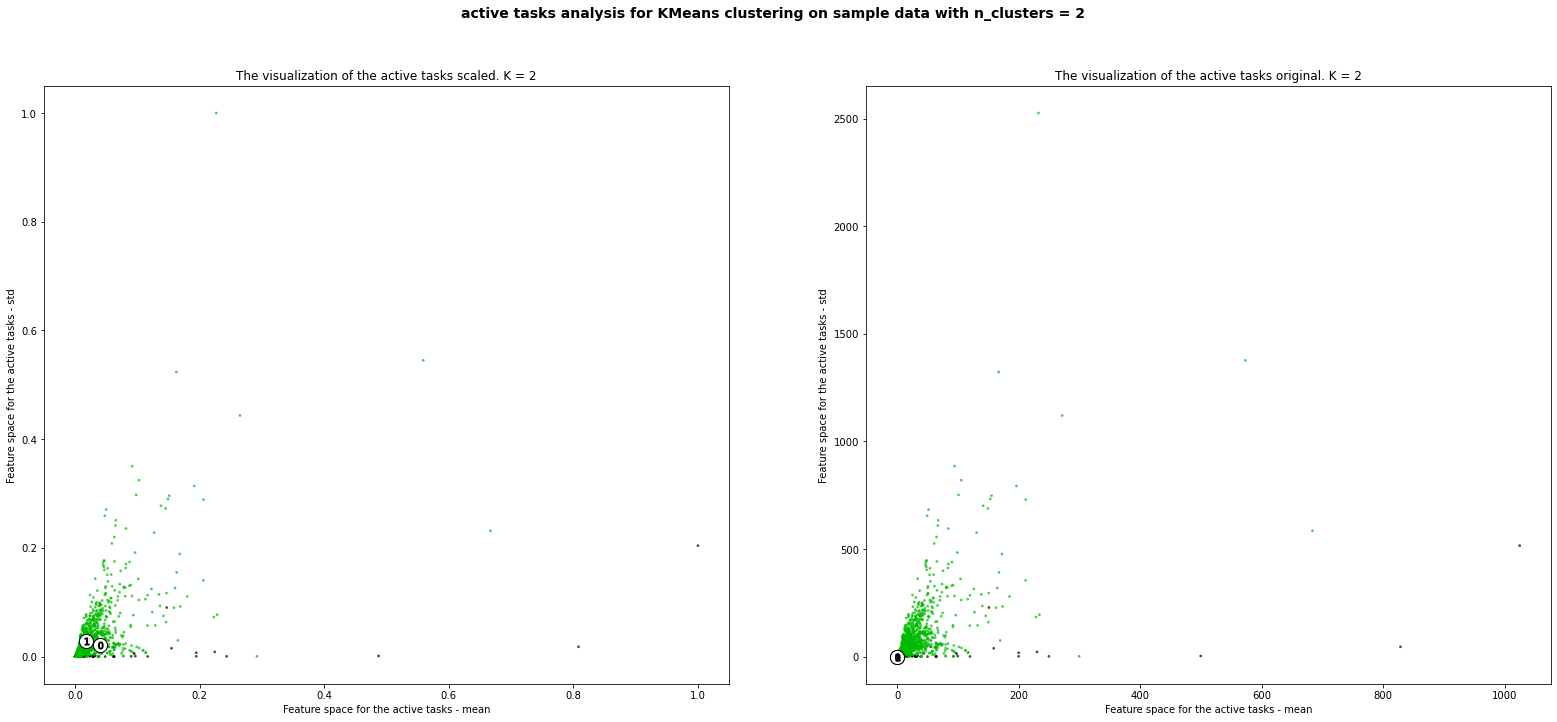

In [48]:
n_clusters = 2

feature = "active tasks"

dim_1 = 6
dim_2 = 7

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer_2, cluster_labels_2, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clusterer_2, cluster_labels_2, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'runtime analysis for KMeans clustering on sample data with n_clusters = 2')

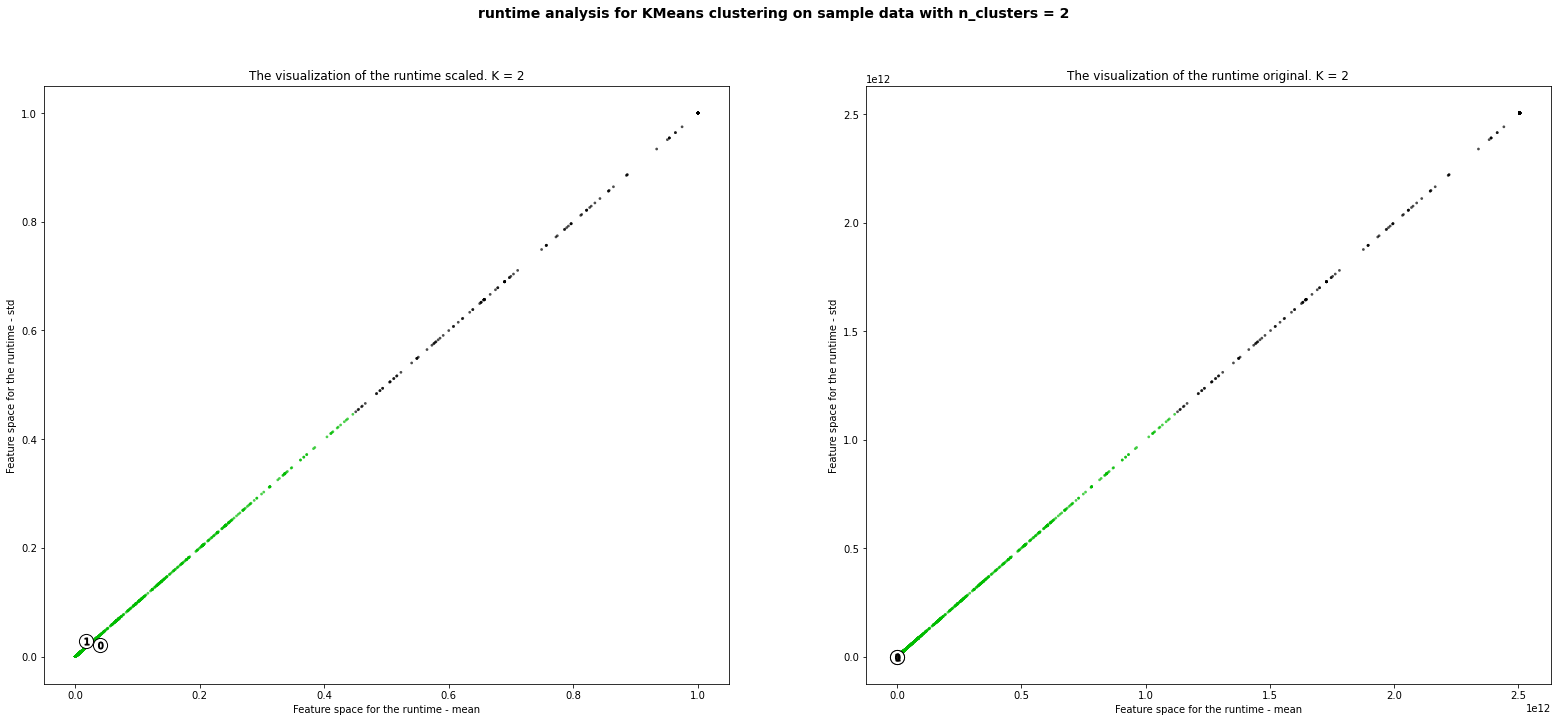

In [39]:
n_clusters = 2

feature = "runtime"

dim_1 = 8
dim_2 = 8

# 2nd Plot showing the actual clusters formed - scaled
#plt.figure(figsize=(12,12))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer_2, cluster_labels_2, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clusterer_2, cluster_labels_2, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

### K-Means = 4

In [40]:
clusterer_4, cluster_labels_4, silhouette_avg_4, sample_silhouette_values_4 = extract_kmeans_stats(scaled, 4)

For n_clusters = 4 The average silhouette_score is : 0.6531772777113841


In [41]:
x = Counter(cluster_labels_4)
for i in range(4):
    print(i, x[i])

0 52169
1 346
2 1076
3 11342


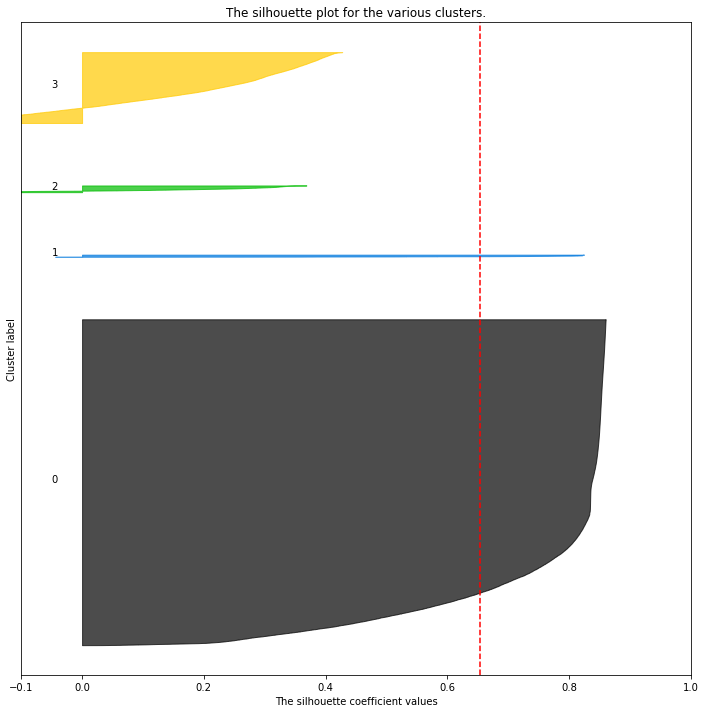

In [42]:
plot_silhouette_results(cluster_labels_4, silhouette_avg_4, sample_silhouette_values_4, 4)

Text(0.5, 0.98, 'CPU rate analysis for KMeans clustering on sample data with n_clusters = 4')

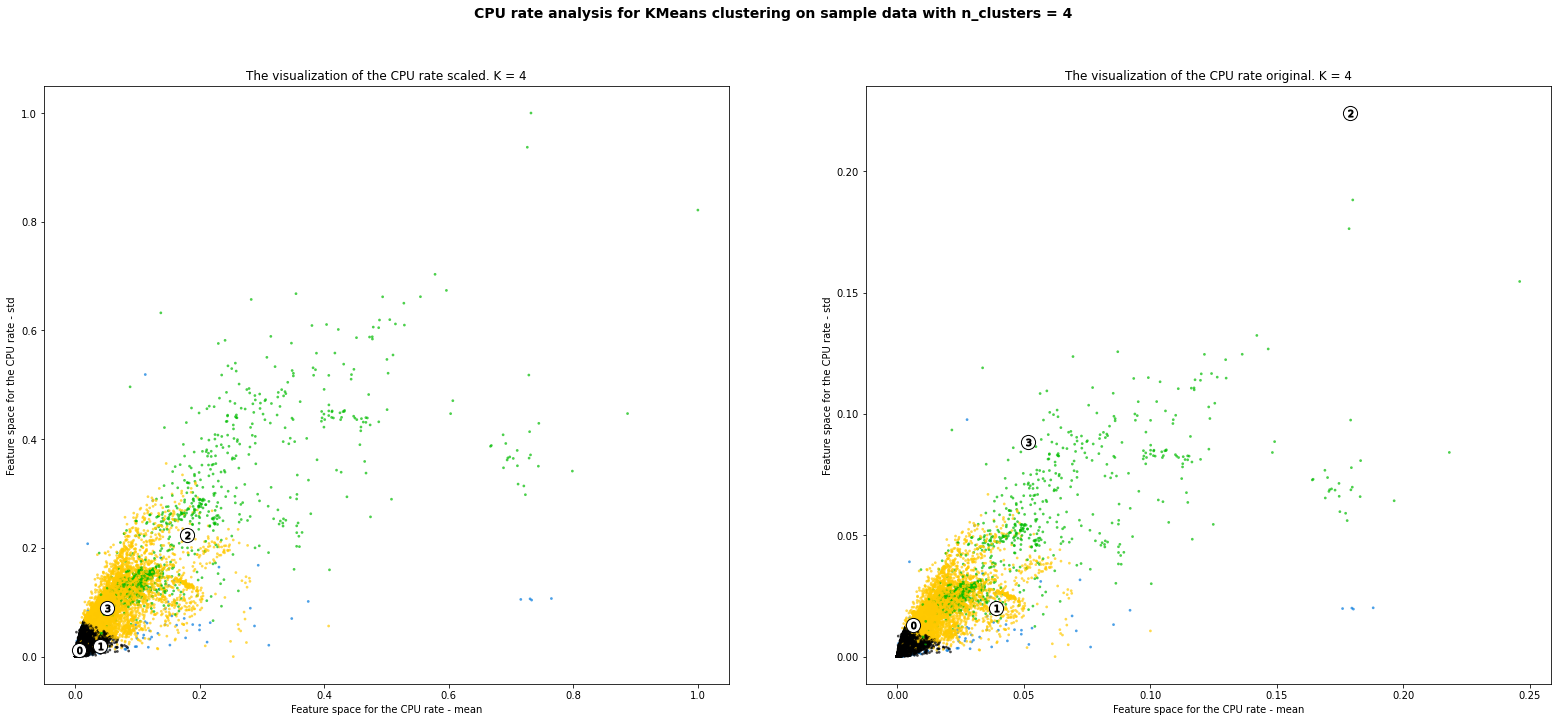

In [49]:
n_clusters = 4

feature = "CPU rate"

dim_1 = 0
dim_2 = 1

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer_4, cluster_labels_4, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clusterer_4, cluster_labels_4, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'canonical memory usage analysis for KMeans clustering on sample data with n_clusters = 4')

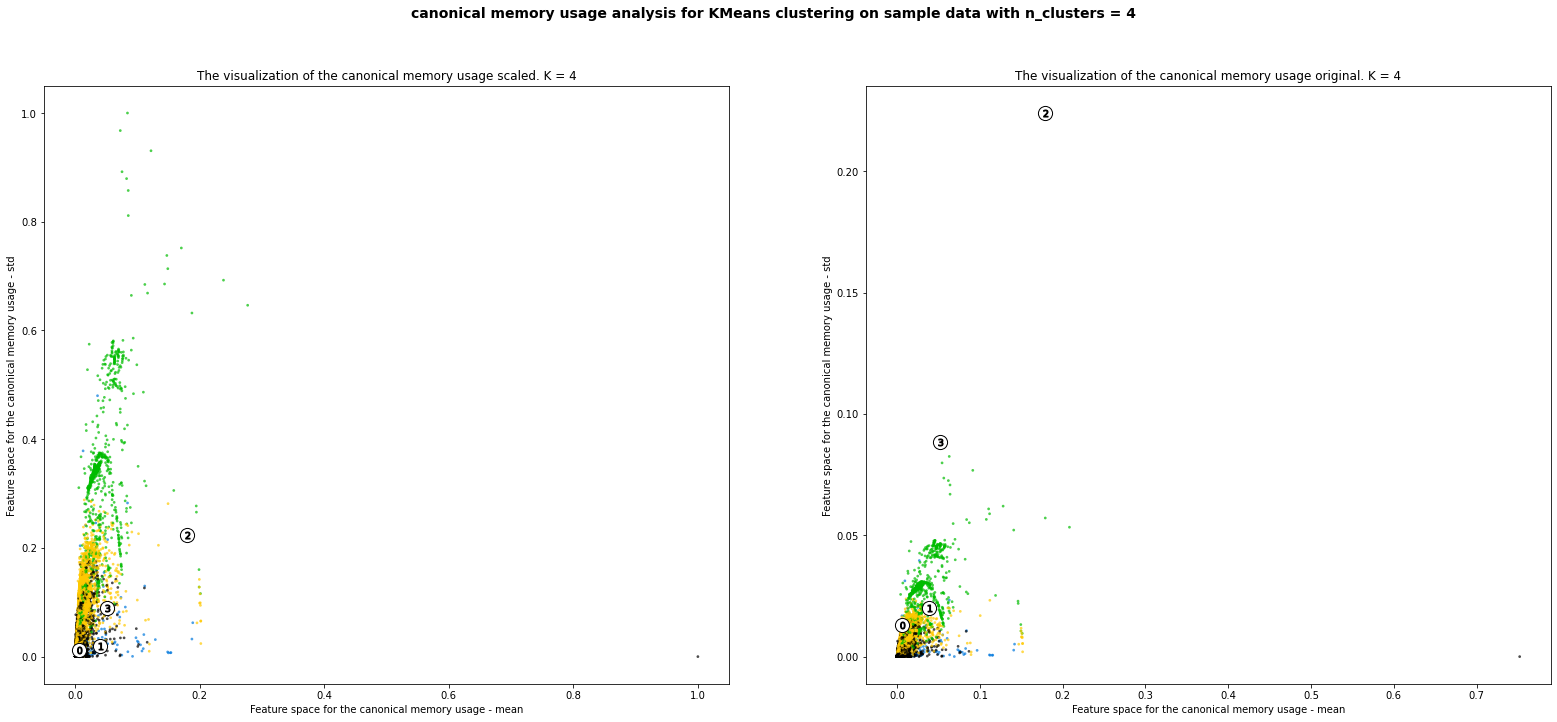

In [44]:
n_clusters = 4

feature = "canonical memory usage"

dim_1 = 2
dim_2 = 3

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer_4, cluster_labels_4, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clusterer_4, cluster_labels_4, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'disk usage analysis for KMeans clustering on sample data with n_clusters = 4')

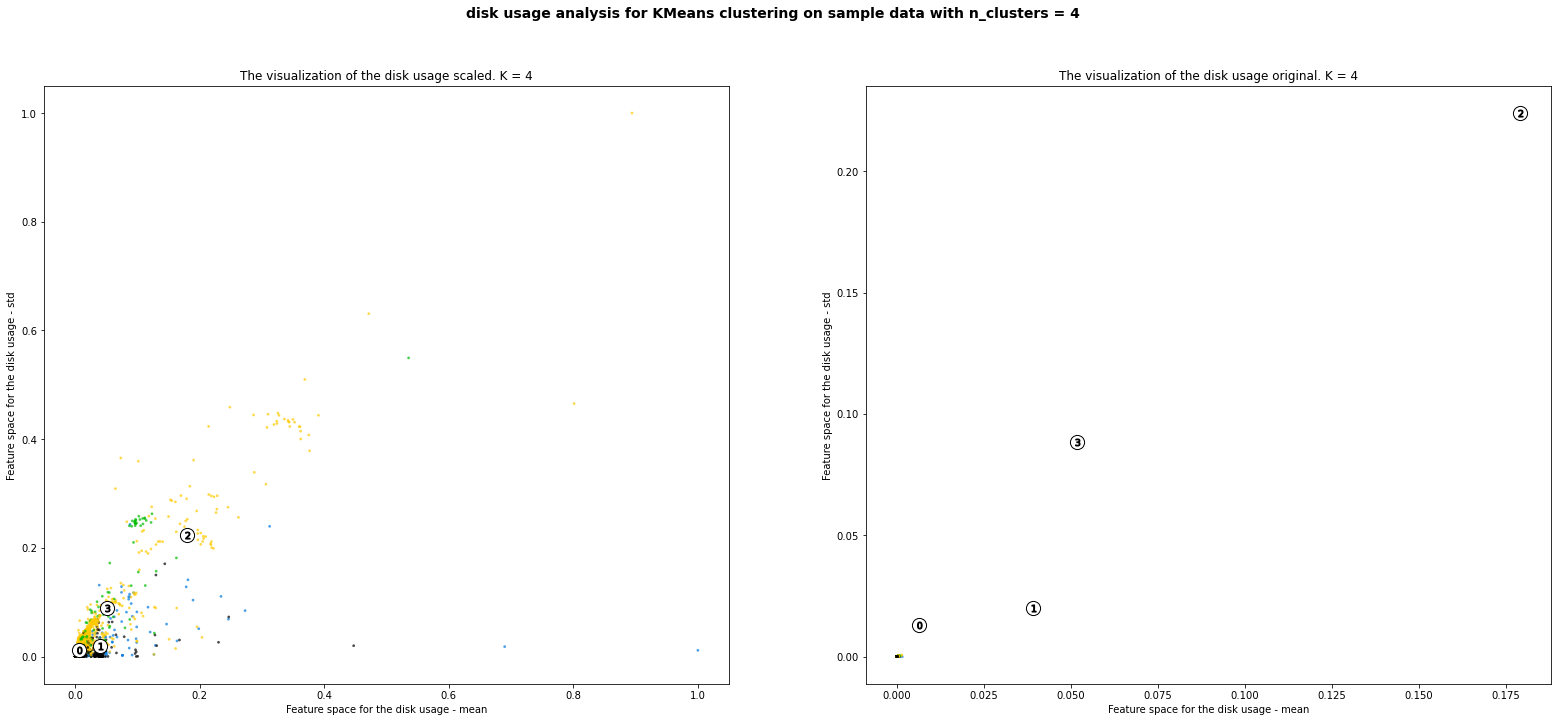

In [45]:
n_clusters = 4

feature = "disk usage"

dim_1 = 4
dim_2 = 5

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer_4, cluster_labels_4, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clusterer_4, cluster_labels_4, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'active tasks analysis for KMeans clustering on sample data with n_clusters = 4')

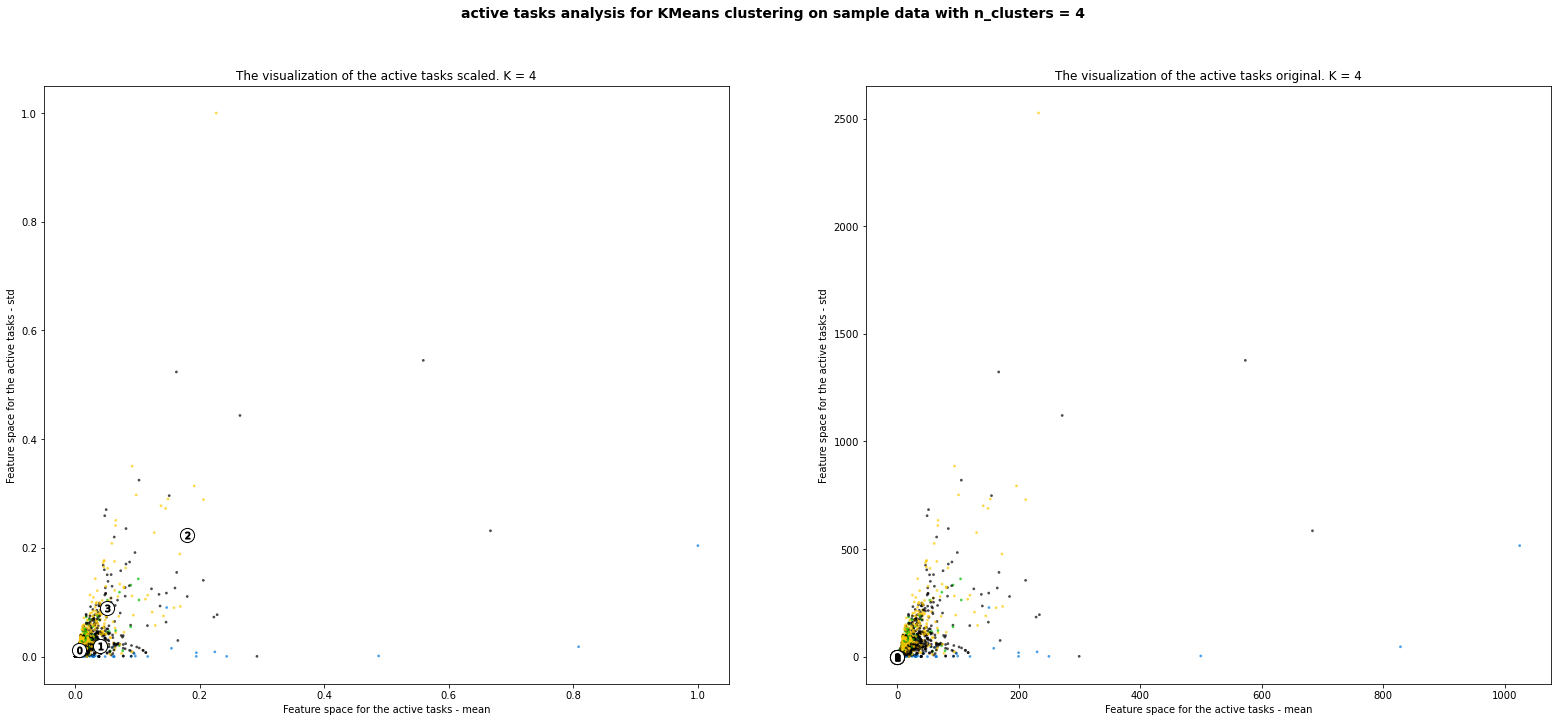

In [50]:
n_clusters = 4

feature = "active tasks"

dim_1 = 6
dim_2 = 7

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer_4, cluster_labels_4, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clusterer_4, cluster_labels_4, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'runtime analysis for KMeans clustering on sample data with n_clusters = 4')

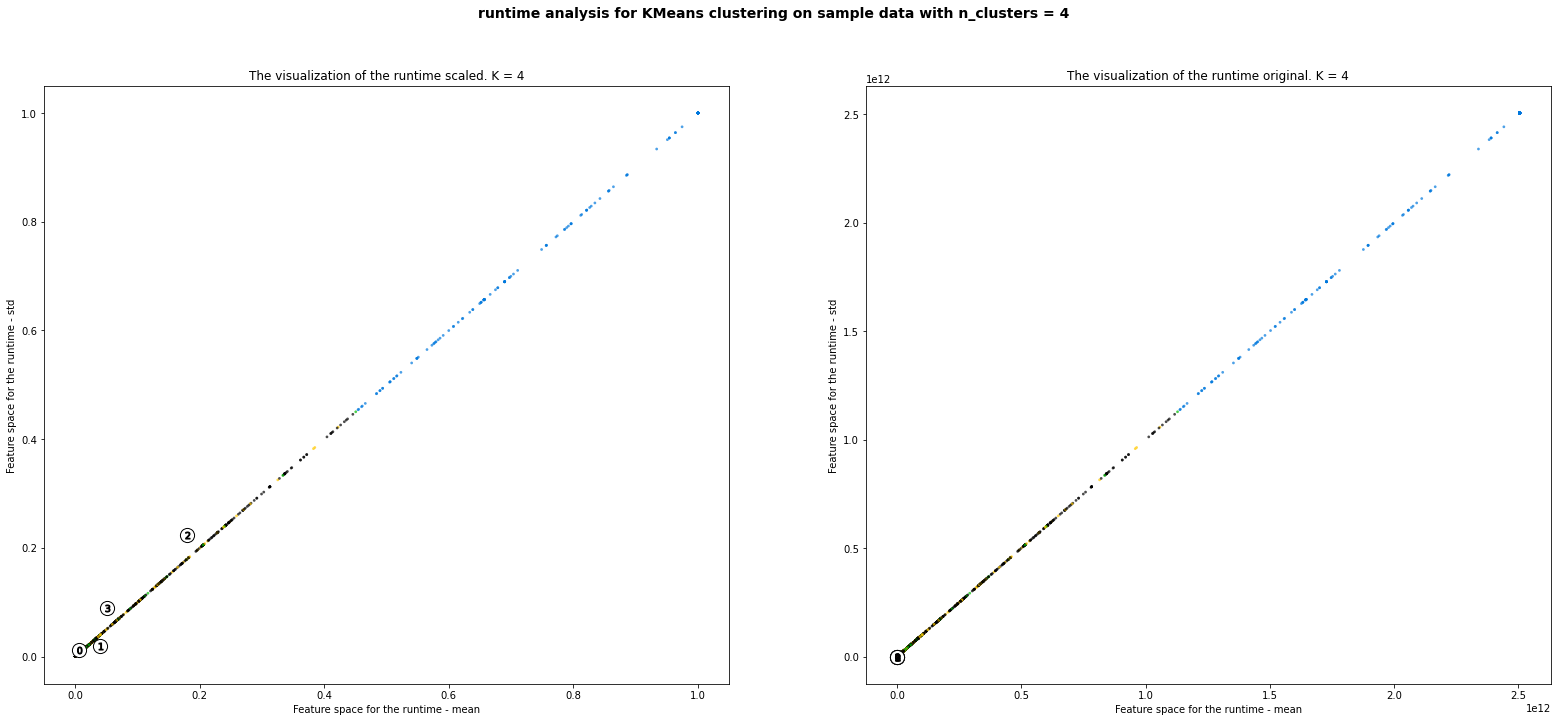

In [51]:
n_clusters = 4

feature = "runtime"

dim_1 = 8
dim_2 = 8

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clusterer_4, cluster_labels_4, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clusterer_4, cluster_labels_4, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

### K-Means = 6

In [52]:
clusterer_6, cluster_labels_6, silhouette_avg_6, sample_silhouette_values_6 = extract_kmeans_stats(scaled, 6)

For n_clusters = 6 The average silhouette_score is : 0.6134780231485698


In [53]:
x = Counter(cluster_labels_6)
for i in range(6):
    print(i, x[i])

0 47330
1 345
2 631
3 13417
4 277
5 2933


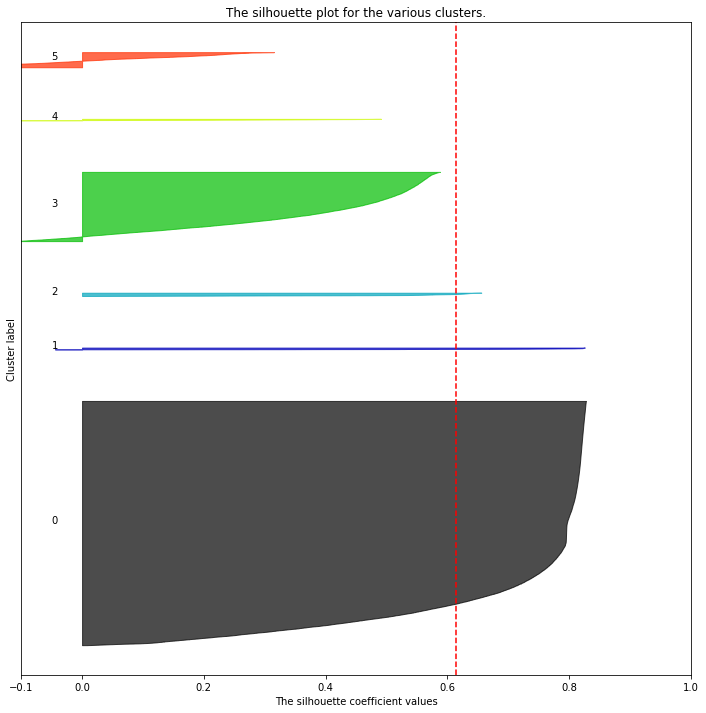

In [54]:
plot_silhouette_results(cluster_labels_6, silhouette_avg_6, sample_silhouette_values_6, 6)

In [55]:
n_clusters = 6
clst = clusterer_6
clst_lbls = cluster_labels_6

Text(0.5, 0.98, 'CPU rate analysis for KMeans clustering on sample data with n_clusters = 6')

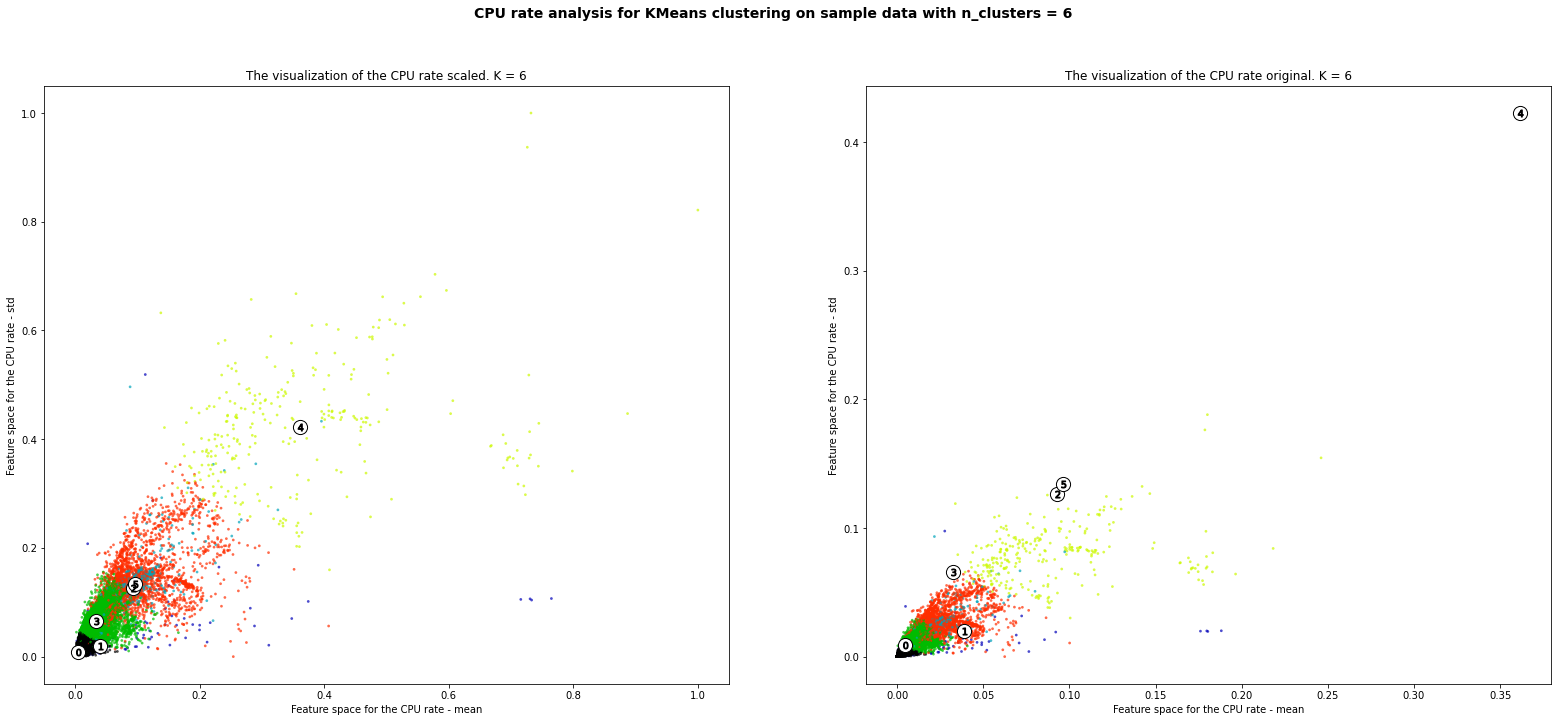

In [56]:
feature = "CPU rate"

dim_1 = 0
dim_2 = 1

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'canonical memory usage analysis for KMeans clustering on sample data with n_clusters = 6')

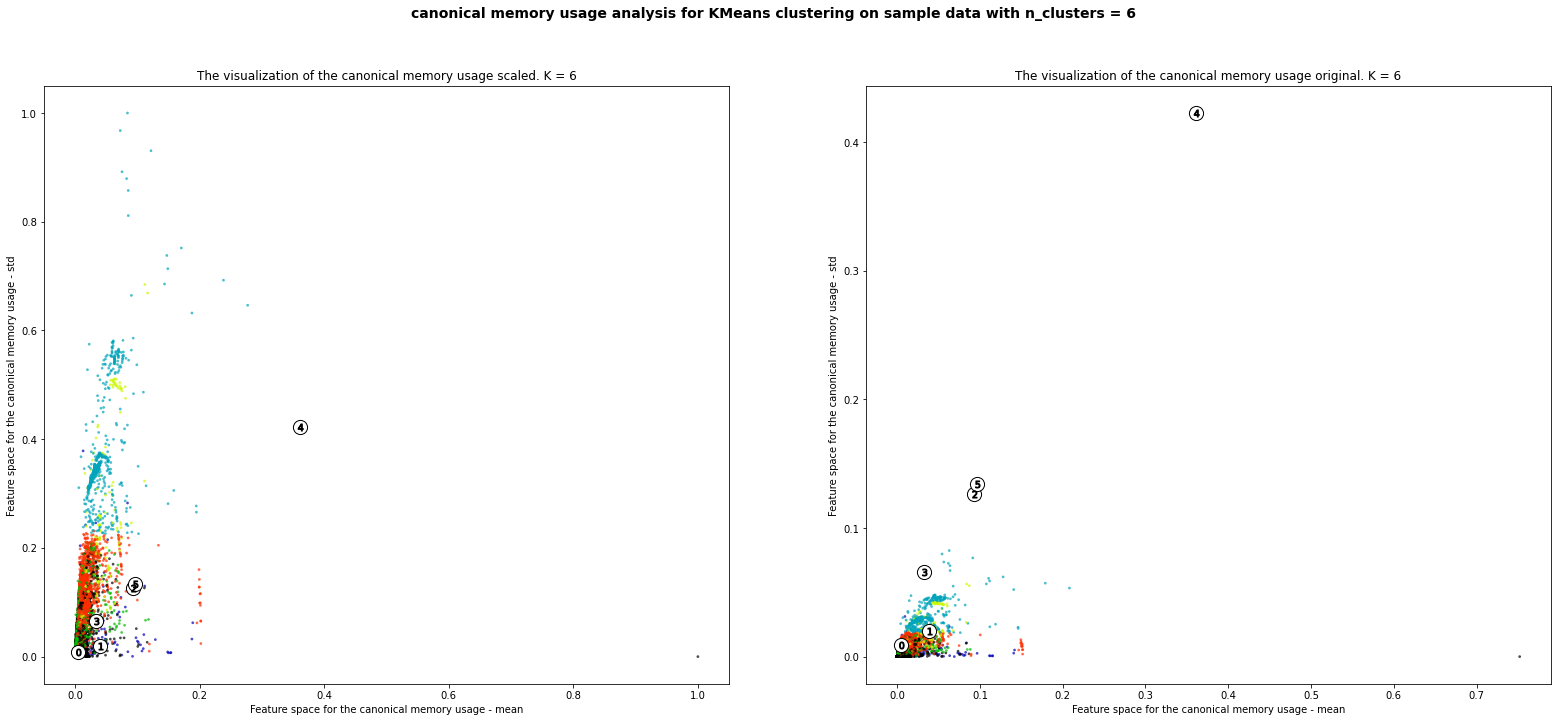

In [57]:
feature = "canonical memory usage"

dim_1 = 2
dim_2 = 3

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'disk usage analysis for KMeans clustering on sample data with n_clusters = 6')

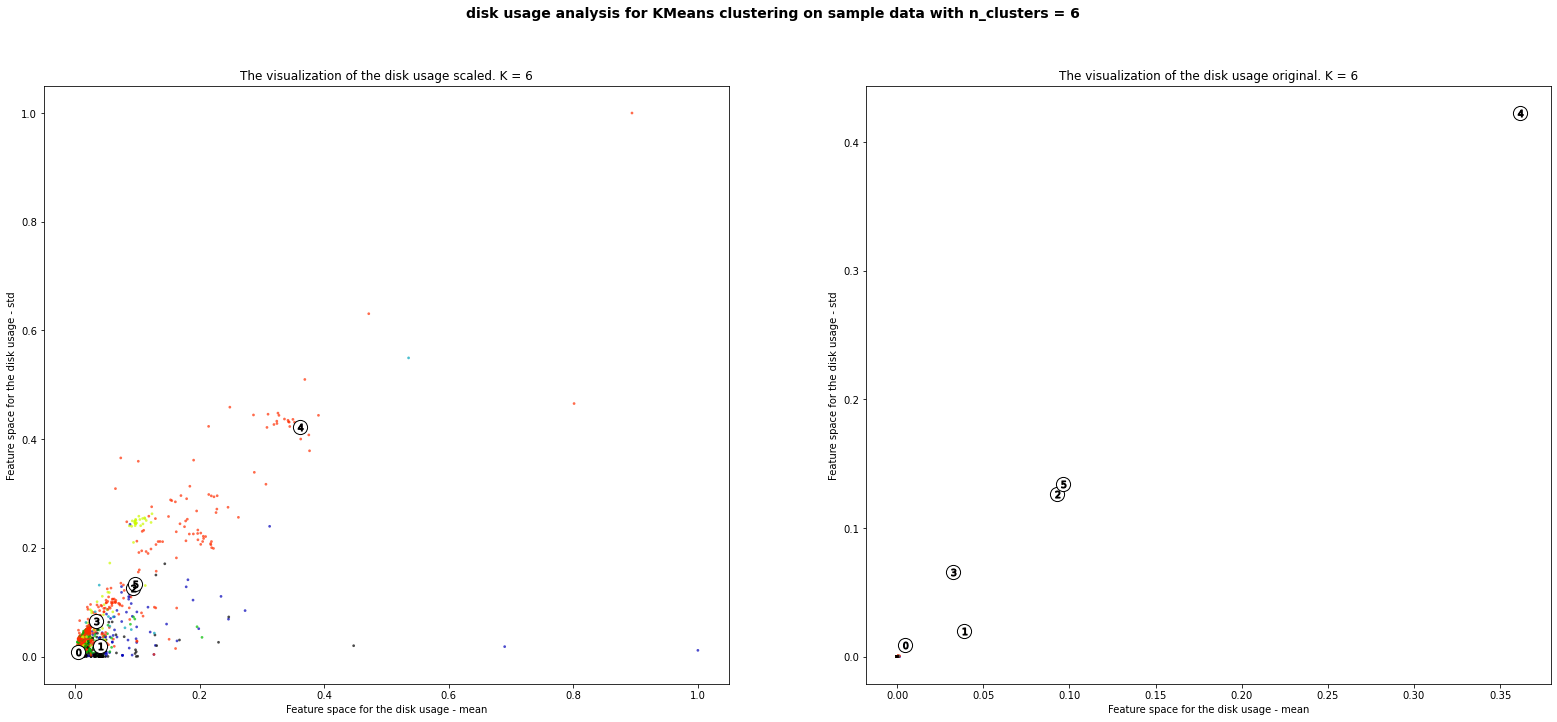

In [58]:
feature = "disk usage"

dim_1 = 4
dim_2 = 5

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'active tasks analysis for KMeans clustering on sample data with n_clusters = 6')

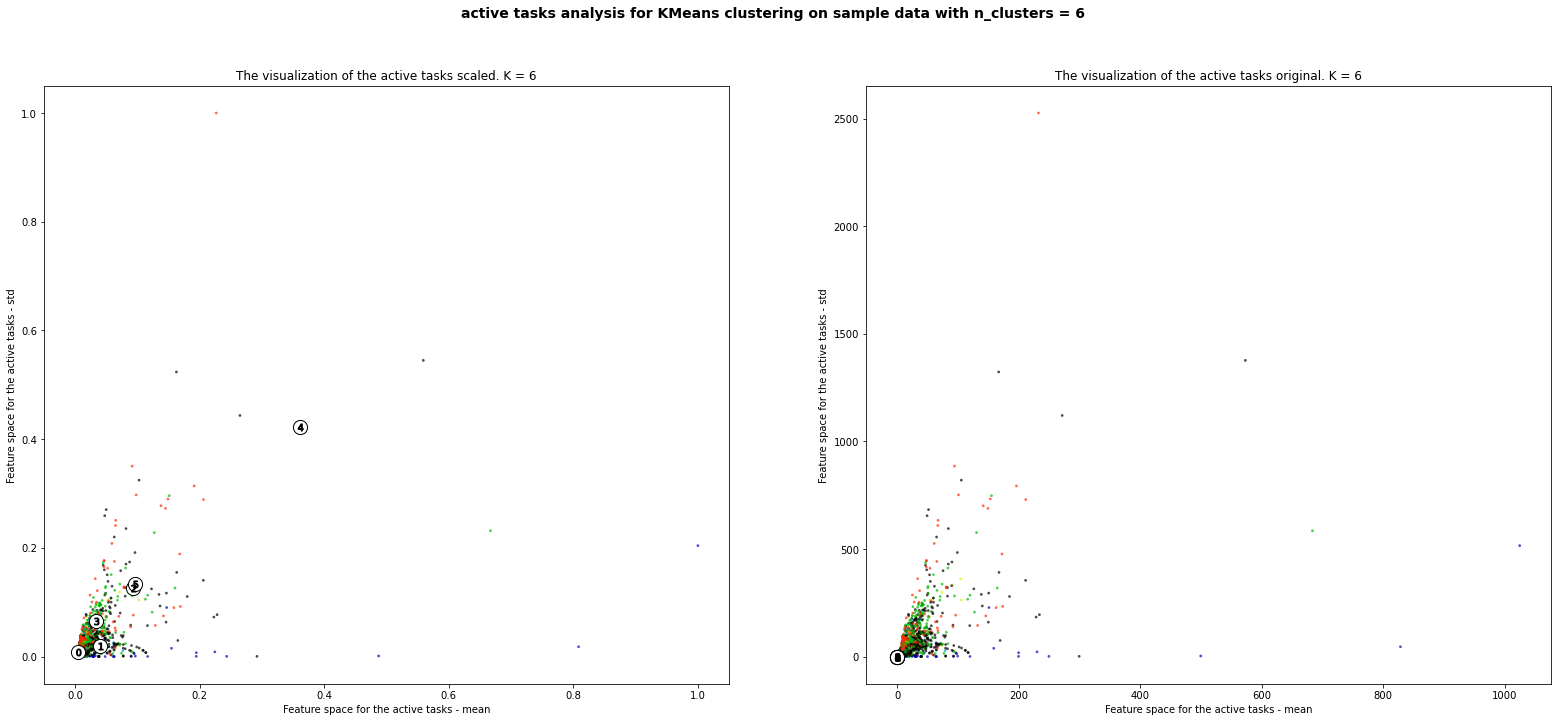

In [59]:
feature = "active tasks"

dim_1 = 6
dim_2 = 7

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'runtime analysis for KMeans clustering on sample data with n_clusters = 6')

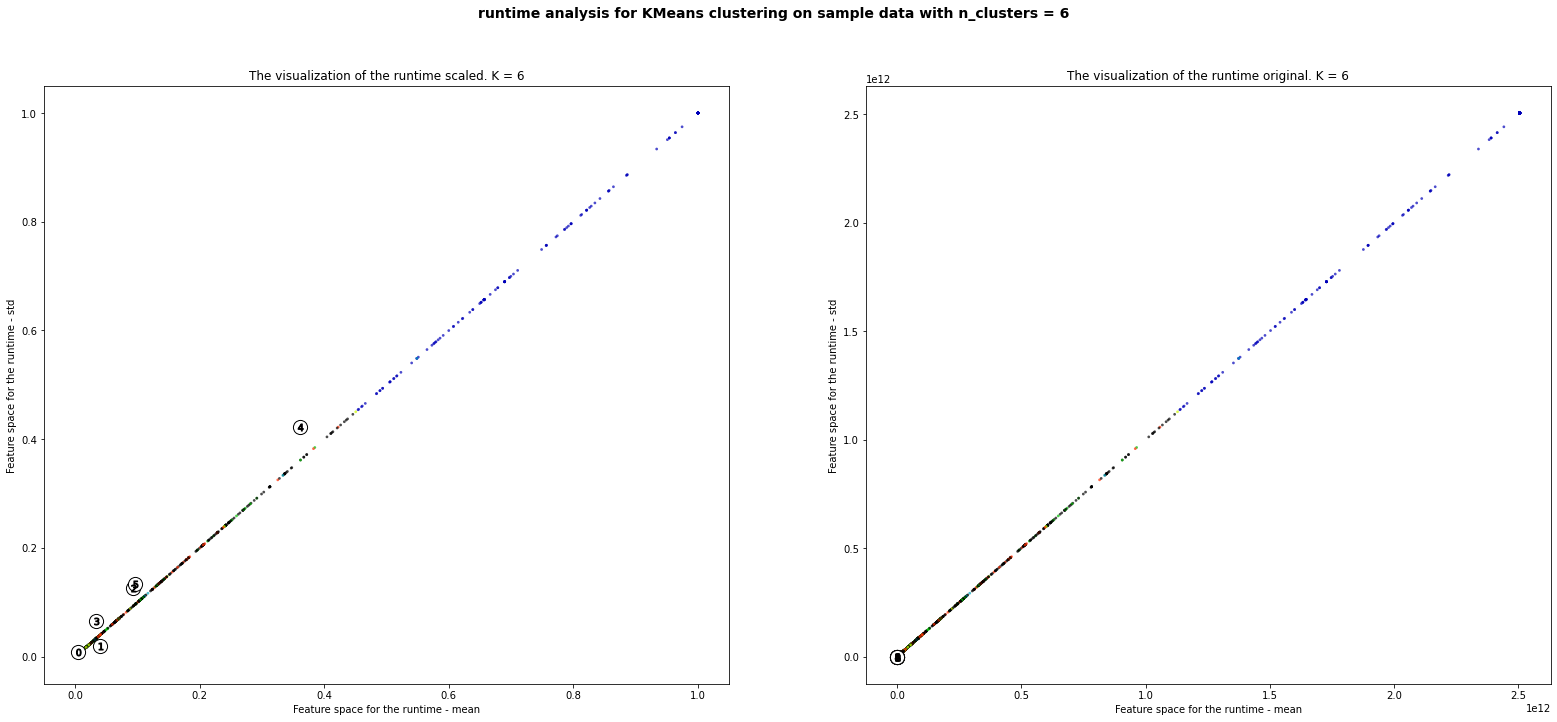

In [60]:
feature = "runtime"

dim_1 = 8
dim_2 = 8

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

### K-Means = 8

In [61]:
clusterer_8, cluster_labels_8, silhouette_avg_8, sample_silhouette_values_8 = extract_kmeans_stats(scaled, 8)

For n_clusters = 8 The average silhouette_score is : 0.6361552741851102


In [62]:
x = Counter(cluster_labels_8)
for i in range(8):
    print(i, x[i])

0 47295
1 308
2 240
3 1713
4 1554
5 13039
6 209
7 575


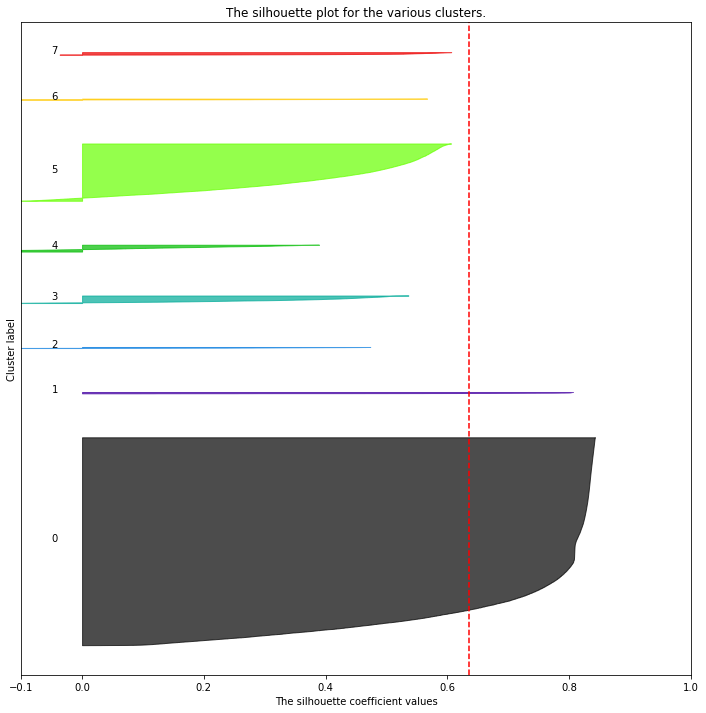

In [63]:
plot_silhouette_results(cluster_labels_8, silhouette_avg_8, sample_silhouette_values_8, 8)

In [64]:
n_clusters = 8
clst = clusterer_8
clst_lbls = cluster_labels_8

Text(0.5, 0.98, 'CPU rate analysis for KMeans clustering on sample data with n_clusters = 8')

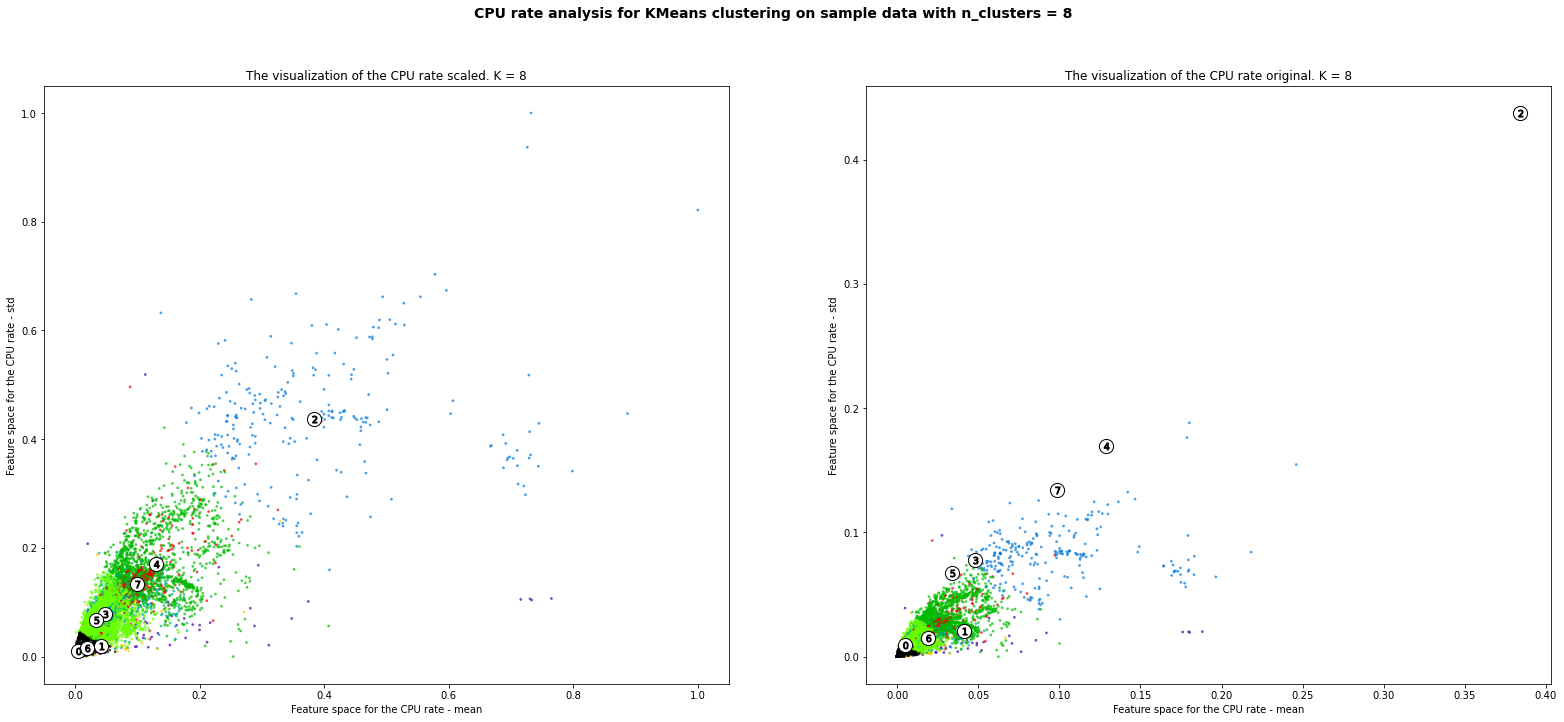

In [65]:
feature = "CPU rate"

dim_1 = 0
dim_2 = 1

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'canonical memory usage analysis for KMeans clustering on sample data with n_clusters = 8')

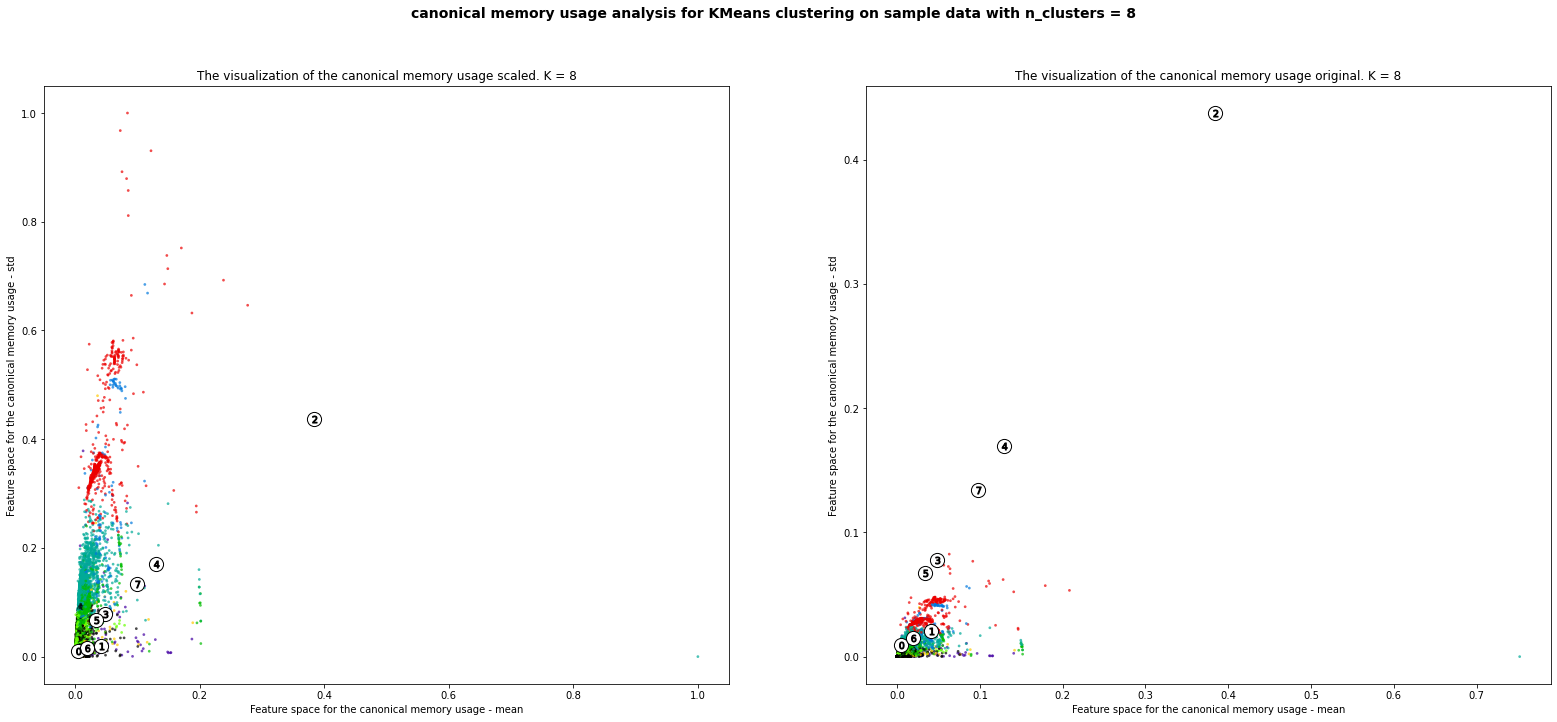

In [66]:
feature = "canonical memory usage"

dim_1 = 2
dim_2 = 3

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'disk usage analysis for KMeans clustering on sample data with n_clusters = 8')

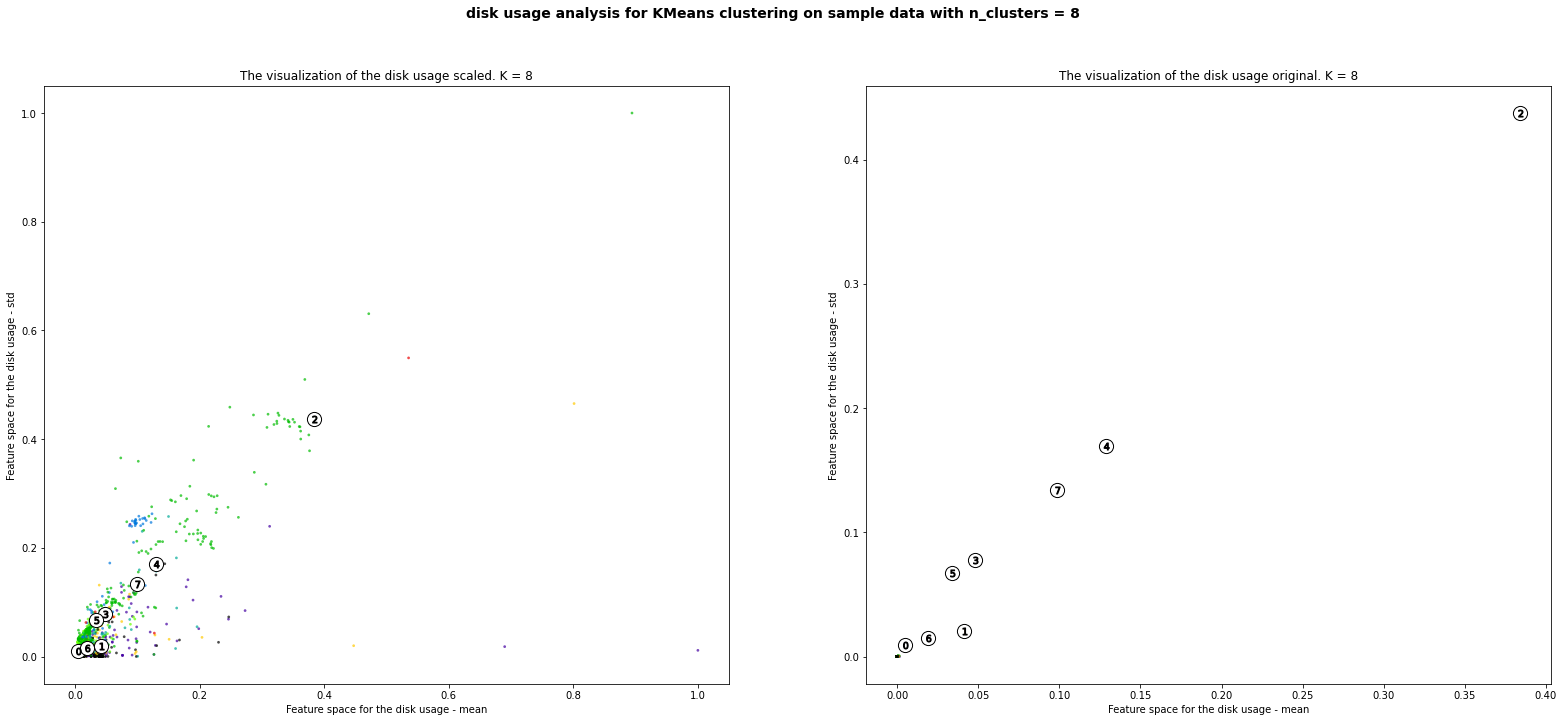

In [67]:
feature = "disk usage"

dim_1 = 4
dim_2 = 5

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'active tasks analysis for KMeans clustering on sample data with n_clusters = 8')

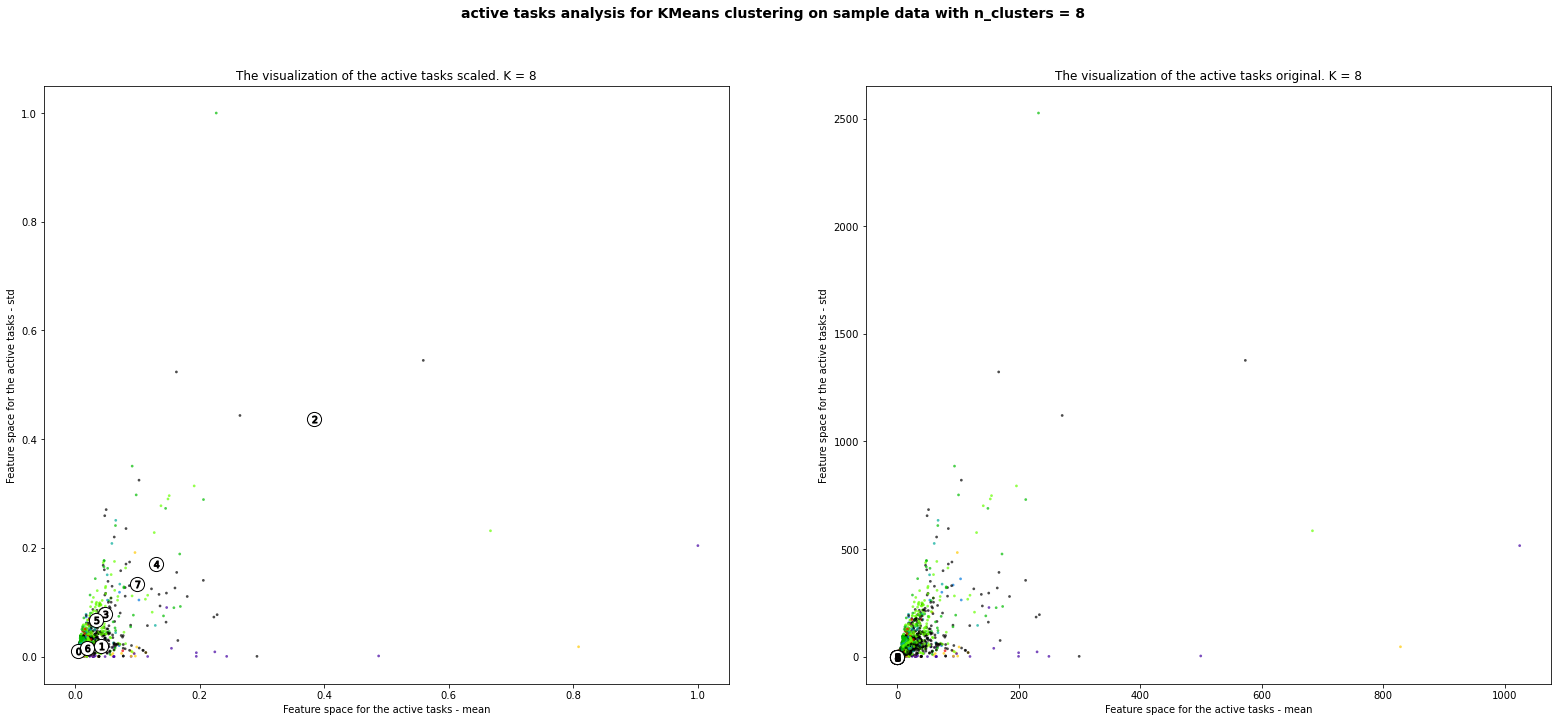

In [68]:
feature = "active tasks"

dim_1 = 6
dim_2 = 7

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'runtime analysis for KMeans clustering on sample data with n_clusters = 8')

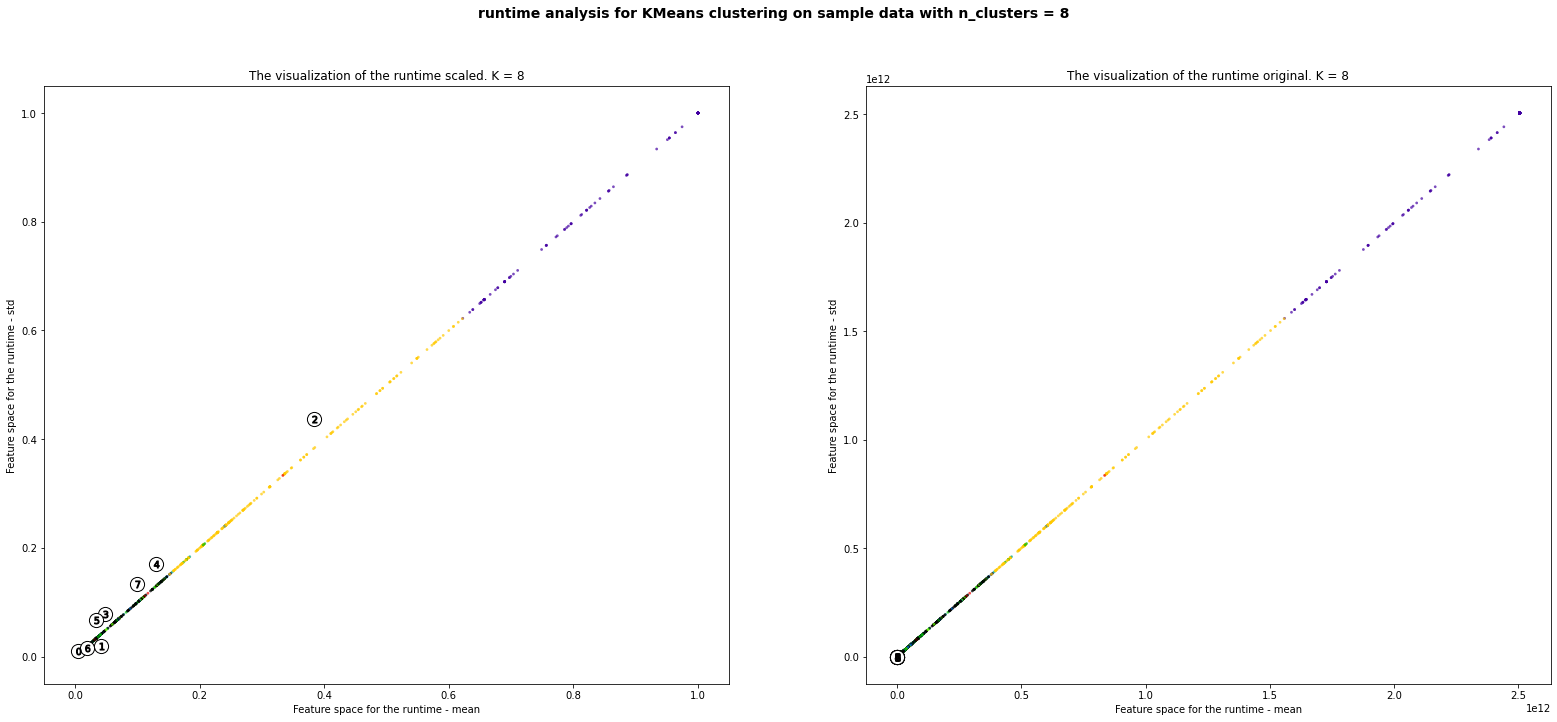

In [69]:
feature = "runtime"

dim_1 = 8
dim_2 = 8

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

### K-Means = 10

In [70]:
clusterer_10, cluster_labels_10, silhouette_avg_10, sample_silhouette_values_10 = extract_kmeans_stats(scaled, 10)

For n_clusters = 10 The average silhouette_score is : 0.5853092929084116


In [71]:
x = Counter(cluster_labels_10)
for i in range(10):
    print(i, x[i])

0 43848
1 308
2 801
3 1673
4 4696
5 12560
6 208
7 568
8 90
9 181


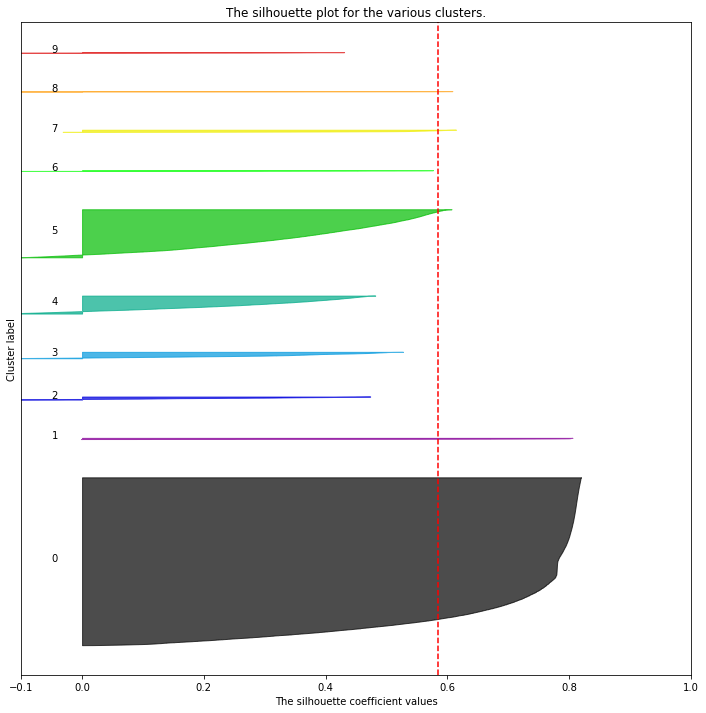

In [72]:
plot_silhouette_results(cluster_labels_10, silhouette_avg_10, sample_silhouette_values_10, 10)

In [73]:
n_clusters = 10
clst = clusterer_10
clst_lbls = cluster_labels_10

Text(0.5, 0.98, 'CPU rate analysis for KMeans clustering on sample data with n_clusters = 10')

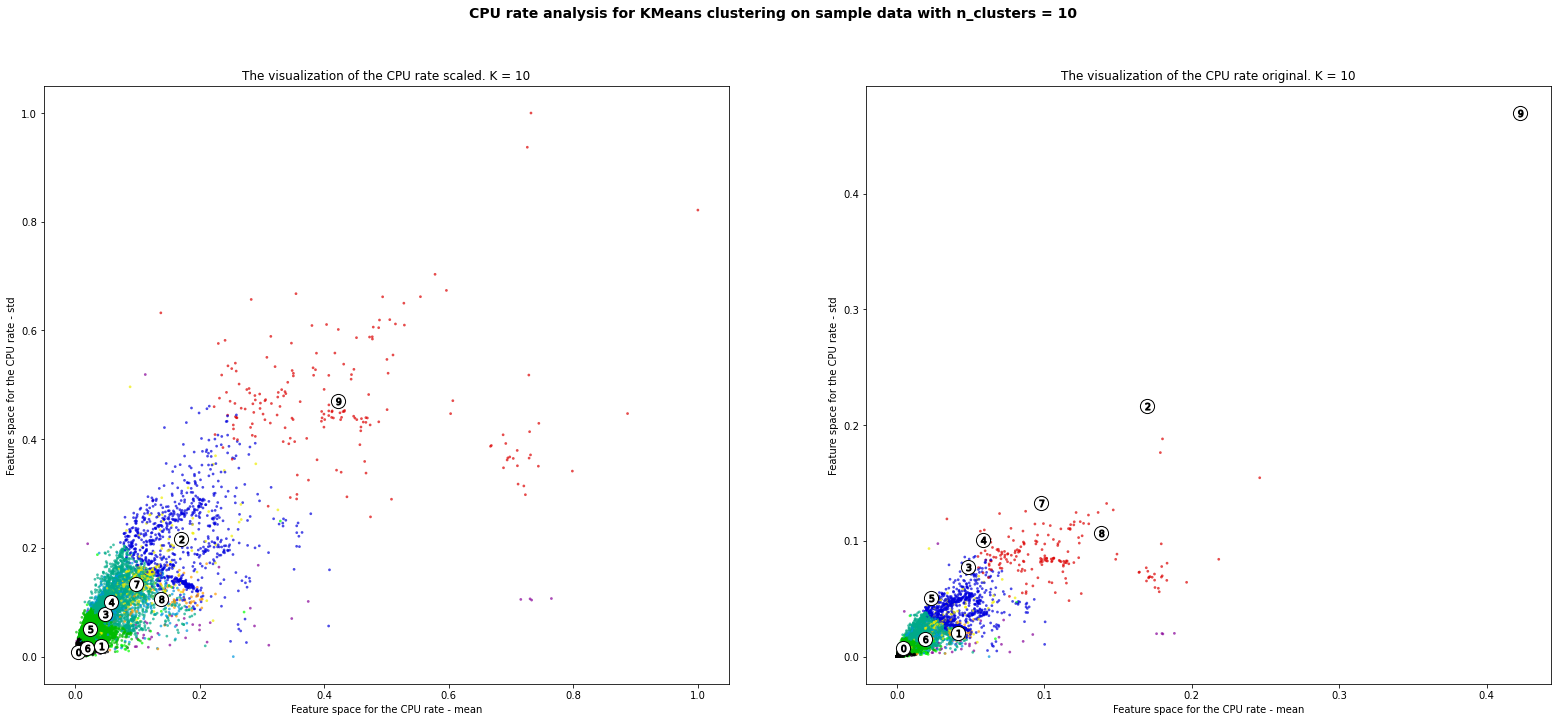

In [74]:
feature = "CPU rate"

dim_1 = 0
dim_2 = 1

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'canonical memory usage analysis for KMeans clustering on sample data with n_clusters = 10')

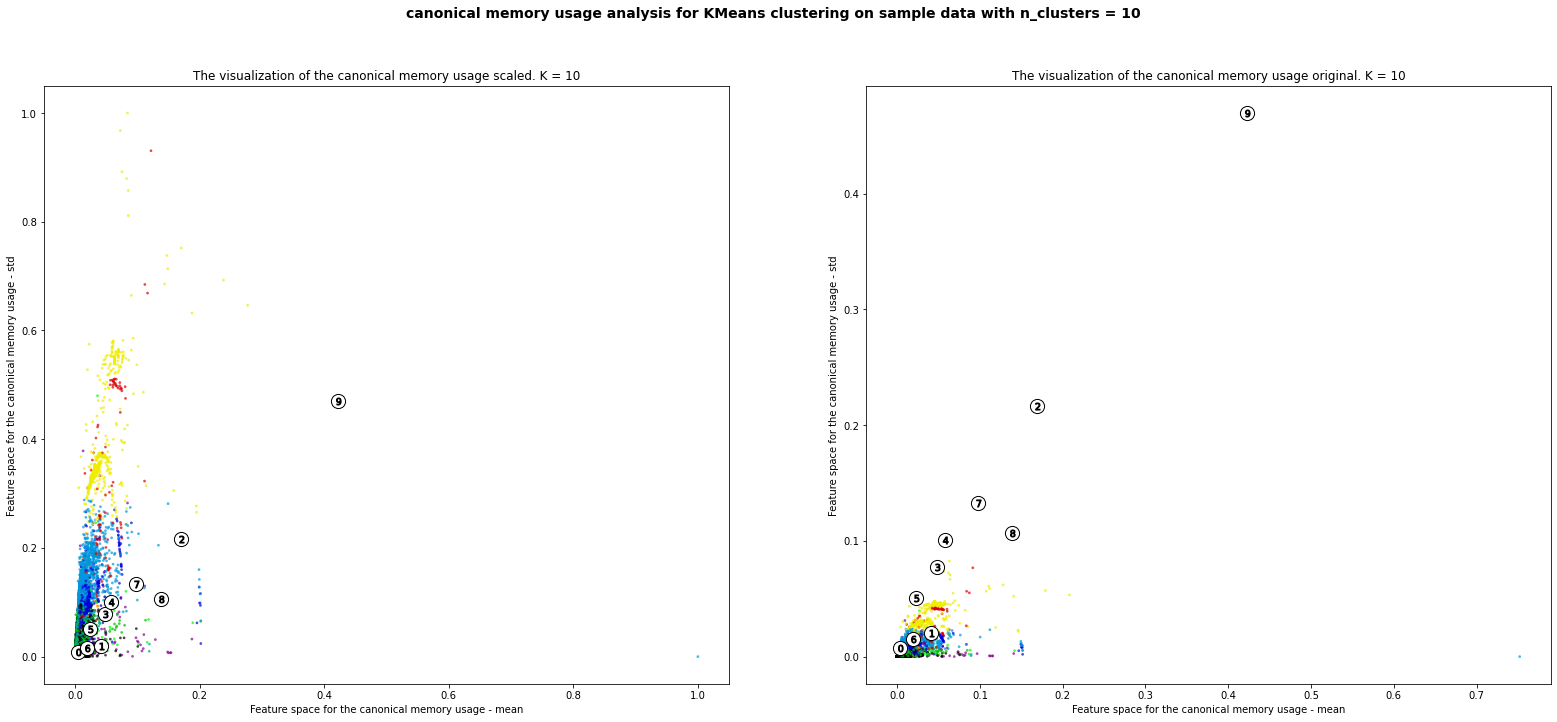

In [75]:
feature = "canonical memory usage"

dim_1 = 2
dim_2 = 3

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'disk usage analysis for KMeans clustering on sample data with n_clusters = 10')

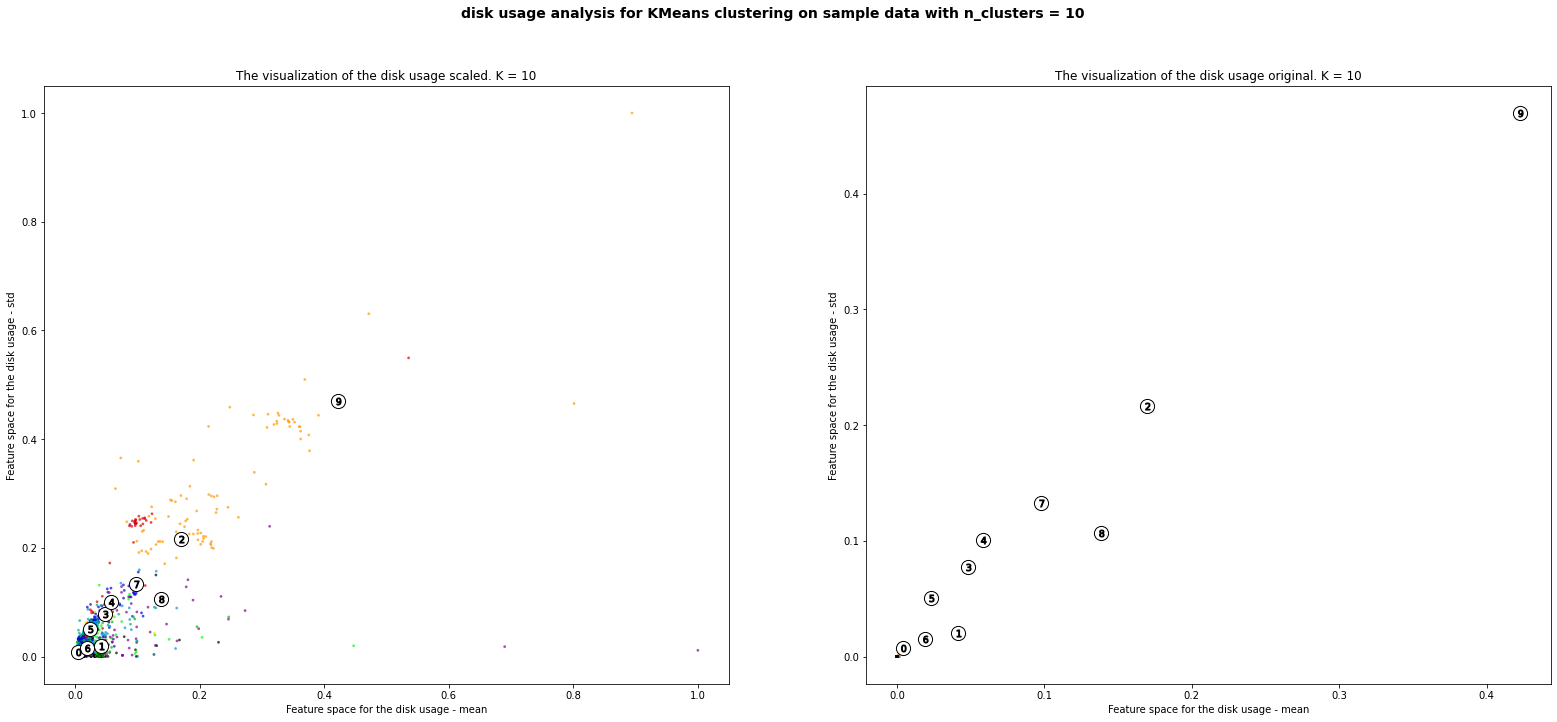

In [76]:
feature = "disk usage"

dim_1 = 4
dim_2 = 5

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'active tasks analysis for KMeans clustering on sample data with n_clusters = 10')

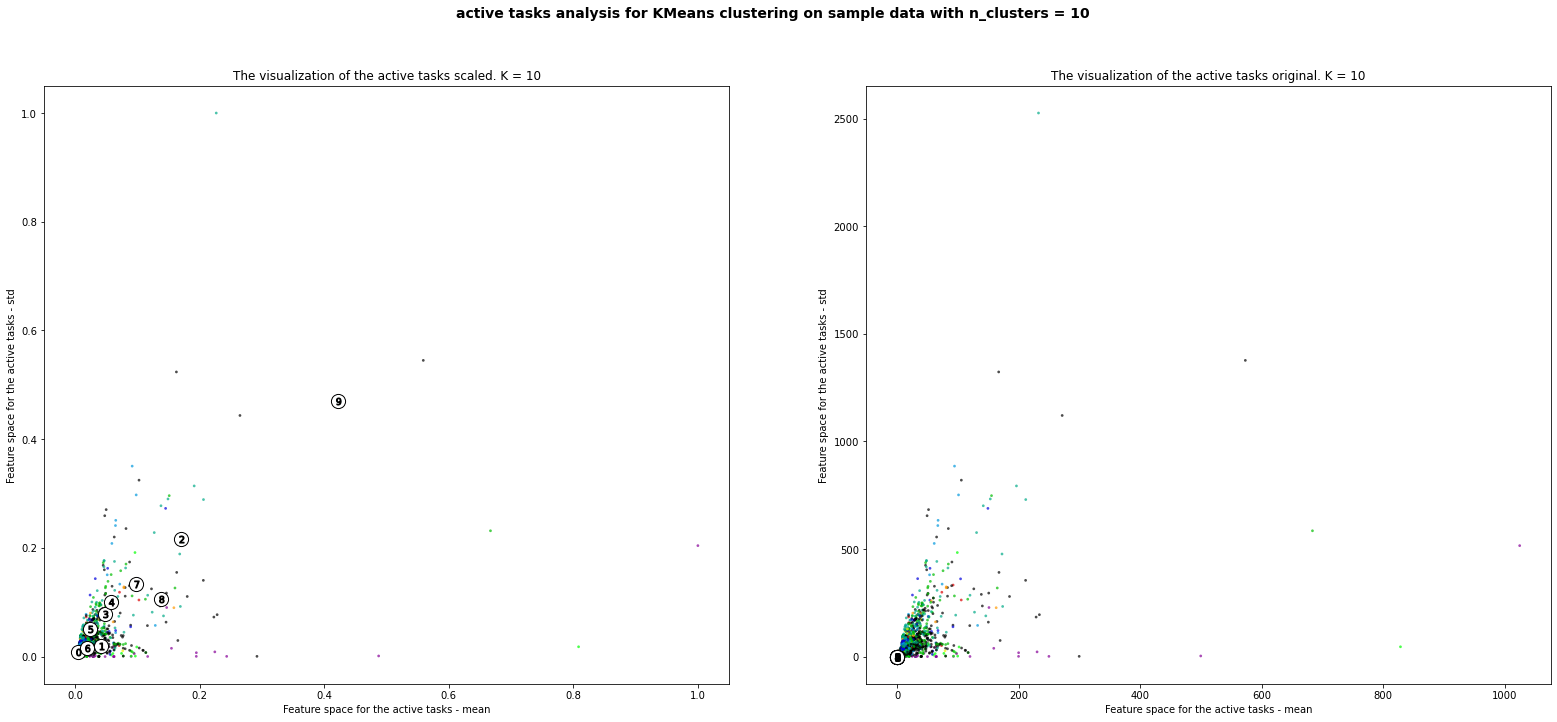

In [77]:
feature = "active tasks"

dim_1 = 6
dim_2 = 7

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'runtime analysis for KMeans clustering on sample data with n_clusters = 10')

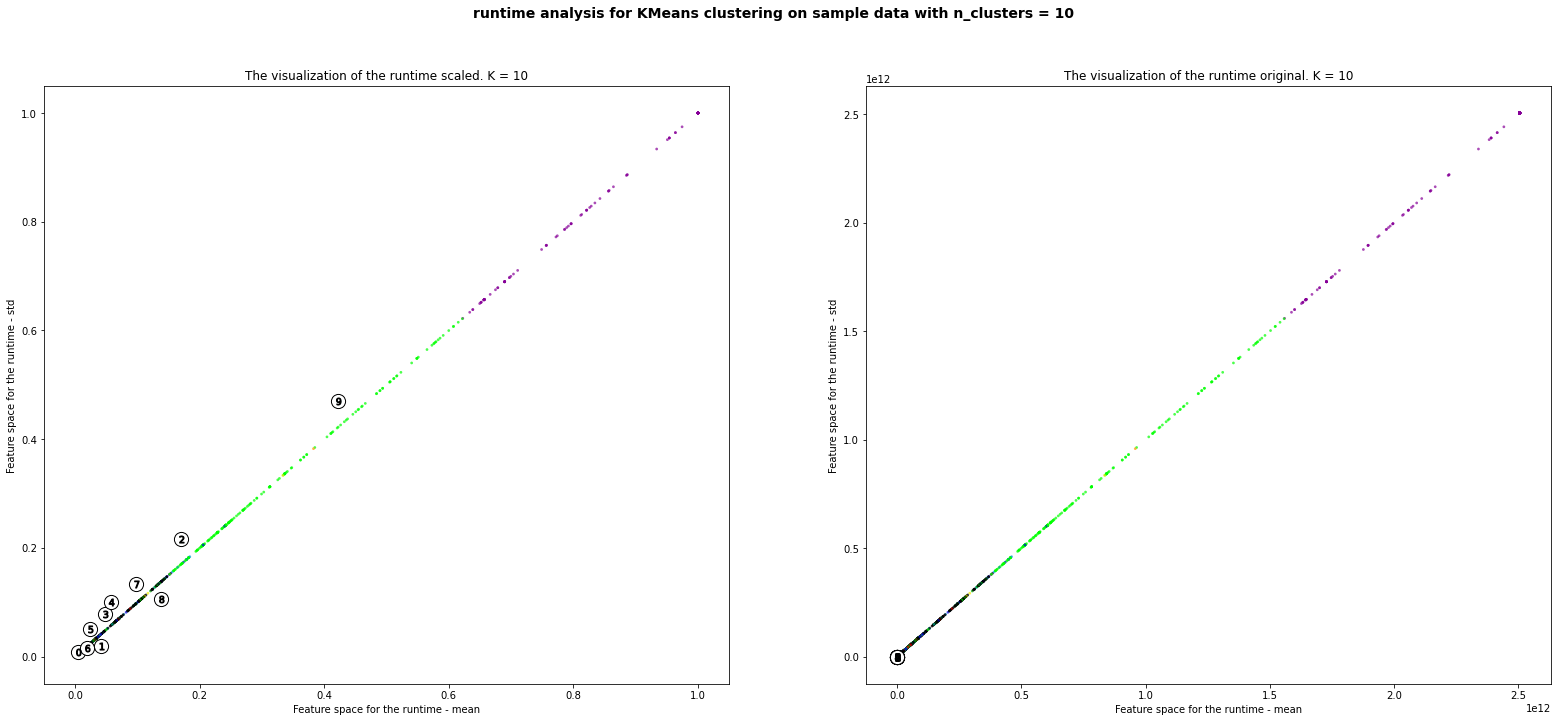

In [78]:
feature = "runtime"

dim_1 = 8
dim_2 = 8

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(27, 11)

plot_feature_scatter(ax1, scaled, clst, clst_lbls, feature, dim_1, dim_2, "scaled", n_clusters)

plot_feature_scatter(ax2, readings_task_usage_df.values, clst, clst_lbls, feature, dim_1, dim_2, "original", n_clusters)

plt.suptitle(("{feature} analysis for KMeans clustering on sample data with n_clusters = {n_clusters}".format(feature=feature, 
                                                                                                              n_clusters=n_clusters)),
             fontsize=14, fontweight='bold')

### Save cluster labels

In [80]:
kmeans_labels = [cluster_labels_2, cluster_labels_4, cluster_labels_6, cluster_labels_8, cluster_labels_10]
pickle.dump(kmeans_labels, open("data/kmeans_labels.p", "wb"))

## Watermark

In [81]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2022-01-25T00:59:23.256847+01:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.18.0-193.28.1.el8_2.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 80
Architecture: 64bit

dask      : 2021.10.0
seaborn   : 0.11.0
pandas    : 1.3.5
numpy     : 1.21.2
sklearn   : 0.23.2
hdbscan   : 0.8.27
matplotlib: 3.4.3

